# Feature-Engineering mit SHAP auf dem Adult census Datensatz 
In der  $\href{https://github.com/ckrech94/masterthesis-explainable-ML/tree/master/thesis}{Arbeit}$ werden zwei Ansätze präsentiert, die bessere Trennschärfe der modernen, hochgradig komplexen Verfahren mit dem erklärbaren Charakter einer logistischen Regression zu kombinieren. Diese führen ein performanceorientiertes Feature Engineering für White-Box-Modelle durch und greifen dabei auf die Erklärungen eines leistungsfähigeren Black-Box-Ansatzes zurück. Dazu wurden zwei verschiedene Methodiken entwickelt, die unabhängig voneinander, aber auch gemeinsam angewendet werden können. Je nach Methodik und Problem, erhöht sich entweder die Performance des
erklärbaren Modells, oder dessen Interpretierbarkeit. In seltenen Fällen ist sogar beides möglich.


In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import sklearn
import sklearn.ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns
import shap
import scipy

from dataset import adult
from model_evaluation import poly_fit, comp_result, test_evaluation

import warnings
warnings.filterwarnings('ignore')


# print the JS visualization code to the notebook
shap.initjs()

### Laden des Datensatzes

In [2]:
X,y = adult()
data = [name for name in X.columns if name not in [y, 'ID']]
X_display, y_display = adult(display=True)
X.fillna(0, inplace=True)

### Trainieren der Baseline-Modelle
Es kommen drei verschiedene Modelle zum Einsatz. 

**Erklärbare Modelle:**
- Logistische Regression
- Entscheidungsbaum der Tiefe 4  

**Black-Box-Verfahren:** 
- Gradient Boosted Machine mit n=1000 Bäumen

Darüber hinaus werden zwei verschiedene Merkmalsräume betrachtet, da die Leistungsfähigkeit der Verfahren stark von der Codierung der kategoriellen Variablen abhängt. Im Merkmalsraum $X$ liegen diese Label-Encoded vor, in $X_{onehot}$ wurden kategorielle Feature in Dummy-Variablen zerlegt.

In [3]:
logreg = LogisticRegression()
dec_tree = DecisionTreeClassifier(max_depth=4,random_state=7)
original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}
clf = sklearn.ensemble.GradientBoostingClassifier(**original_params)
X_one_hot = pd.get_dummies(X, prefix_sep='_',columns = ['Occupation','Relationship',
                                                        'Marital Status', 'Race',
                                                        'Workclass', 'Country','Sex'])
result_log_reg = comp_result(logreg,X_one_hot,y )
result_dec_tree = comp_result(dec_tree,X_one_hot,y )
result_gbm = comp_result(clf,X_one_hot,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X,y )
result_dec_tree = comp_result(dec_tree,X,y )
result_gbm = comp_result(clf,X,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')


____________One-Hot-Encoding____________
Logistische Regression: 0.906180220829242 (0.004189588609693335)
Entscheid.baum(Tiefe4): 0.8700922619889611 (0.004141279088467594)
Grad. Boosted Machine : 0.9284728810913581 (0.0019572189329325833)
_____________Value-Encoding_____________
Logistische Regression: 0.8880981940700508 (0.0050949884864326805)
Entscheid.baum(Tiefe4): 0.8705855305278174 (0.004112981510506731)
Grad. Boosted Machine : 0.9282809880653955 (0.0020461566506519563)


### Testen der statistischen Signifikanz der Performance-Unterschiede mit der 5x2CV 

In [289]:
test_log_reg = test_evaluation(logreg,X_one_hot,y)
test_gbm = test_evaluation(clf,X,y)
print(test_log_reg)
print(test_gbm)
scipy.stats.ttest_rel(test_log_reg[1],test_gbm[1])

(0.002735298155622026, [0.9016406695051156, 0.9068575123837608, 0.9052061706111432, 0.9050679422080024, 0.9009780371503995, 0.9094647032021029, 0.9019569032079249, 0.9078936564948537, 0.9024819030566884, 0.9058071609835435])
(0.0027127806197413382, [0.9232850146697092, 0.9301968830429779, 0.9254801756972904, 0.9272714548712255, 0.9241591448937007, 0.9306864317961523, 0.92279798806878, 0.9292300112939063, 0.9287425494612374, 0.9269635839692781])


Ttest_relResult(statistic=-40.1531920146777, pvalue=1.8344240930346595e-11)

## Methode 1: Feature Engineering mit SHAP-Erklärungen eines Black-Box-Modells
Die erste Methodik bedient sich der strukturellen Unterschiede zwischen White- und Black-Box-Verfahren in Bezug auf die funktionale Form der daraus resultierenden Modelle. Es werden vier wesentliche Unterschiede
zwischen erklärbaren und intransparenten ML-Algorithmen dargelegt, die die oft überlegene Performance der Black-Box-Verfahren, gleichzeitig aber auch deren hohen Grad an Intransparenz begründen: 
- Die implizite Merkmalsauswahl 
- Das Vorhandensein nicht linearer Effekte 
- Komplexe Interaktionen 

Diese Methodik bedient sich den SHAP-Erklärungen der Gradient Boosting Machine, um die drei Vorteile des Black-Box-Modells den beiden erklärbaren Modellen zur Verfügung zu stellen. Da SHAP-Erklärungen, und alle sich daraus ergebenden Transformationen des Merkmalsraums, nur für einen Train-Test sinnvoll berechenbar sind, wird nur ein 80-20 Split betrachtet. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=7)
original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}
clf = sklearn.ensemble.GradientBoostingClassifier(**original_params)
clf.fit(X_train,y_train)

## I. Feature Importance [Entfernen unwichtiger Variablen]
Es folgt die Berechnung der Merkmalswichtigkeit via Gini Wichtigkeit und SHAP

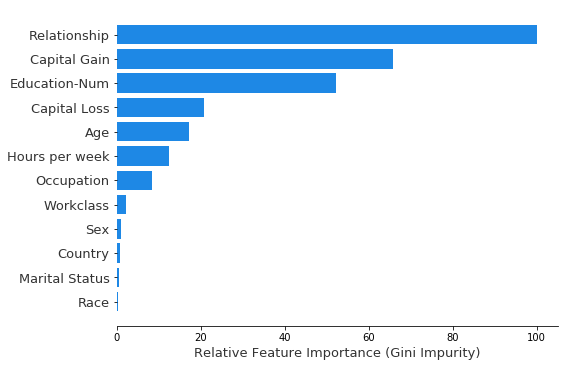

In [13]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig, ax = plt.subplots(figsize=(1.5 * 4.6 + 1, 0.8 * 6 + 1))
ax.barh(pos, feature_importance[sorted_idx], align='center',color = "#1E88E5")
plt.yticks(pos, np.array(list(X))[sorted_idx],  color="#333333", fontsize=13)
ax.set_xlabel('Relative Feature Importance (Gini Impurity)', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.show()

In [14]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shapley = pd.DataFrame(shap_values, columns=list(X))

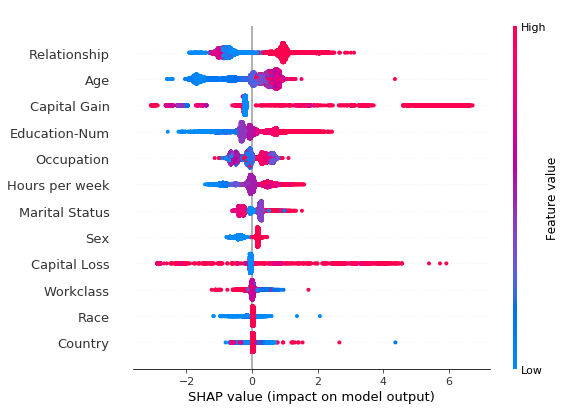

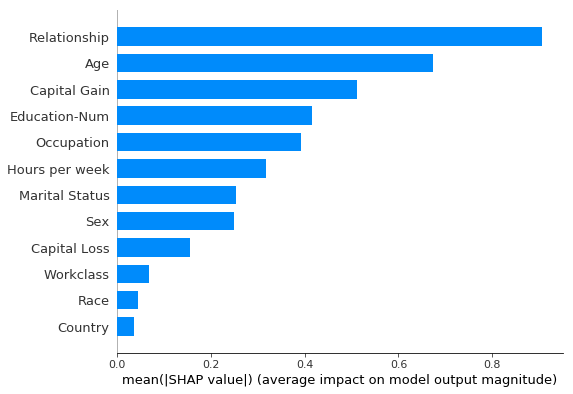

In [15]:
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type='bar')

Die Merkmale *Race, Workclass* und *Country* werden entfernt. Die Modelle werden retrainiert und anschließend erneut kreuzvalidiert.  

In [16]:
X_n = X.drop(['Race', 'Workclass', 'Country'], axis=1)
X_new = X_n.copy()
X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship',
                                                        'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')


____________One-Hot-Encoding____________
Logistische Regression: 0.9045061803896527 (0.003924616182952376)
Entscheid.baum(Tiefe4): 0.8699624564029126 (0.004222329112973607)
Grad. Boosted Machine : 0.9276931487043095 (0.001883709153831356)
_____________Value-Encoding_____________
Logistische Regression: 0.8866703729948021 (0.006875511891532568)
Entscheid.baum(Tiefe4): 0.8705855305278174 (0.004112981510506731)
Grad. Boosted Machine : 0.9274990356634069 (0.0018921903378697421)


## II. Feature Transformation anhand von SHAP
Es folgt das Integrieren von nichtlinearen Zusammenhängen zwischen Merkmalen und Modellvorhersage. Dazu werden *SHAP Dependence Plots* erzeugt. Daraus lassen sich, in Abhängigkeit vom Merkmalstyp, geschickte Transformationen ableiten. Die Merkmale werden in der Reihenfolge ihrer Relevanz im *SHAP Summary Plot* der Gradient Boosting Machine transformiert und in die White-Box-Modelle integriert.  

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state=7)
clf.fit(X_train,y_train)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)
shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(X_train.iloc[:8000,:])

### Merkmal Relationship

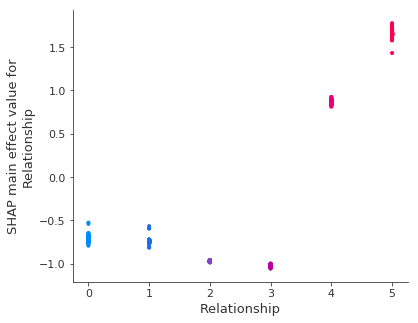

In [18]:
shap.dependence_plot(
    ("Relationship", "Relationship"), 
    shap_interaction_values, X_train.iloc[:8000,:], 
)

In [19]:
X_new['Relationship'] = pd.cut(X['Relationship'], bins=[-1,0,1,3,4,120], include_lowest=True, 
                                labels=['allein', 'verwandt', 'verwandt_1', 'verheiratet_0','verheiratet'])
X_new['Relationship'] = X_new['Relationship'].astype('category').cat.codes
X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship',
                                                        'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9043142986302332 (0.0034845292644954387)
Entscheid.baum(Tiefe4): 0.8700922619889611 (0.004141279088467594)
Grad. Boosted Machine : 0.9277669001370867 (0.0018099385127692289)
_____________Value-Encoding_____________
Logistische Regression: 0.8890151493859315 (0.005103238030937198)
Entscheid.baum(Tiefe4): 0.8705855305278174 (0.004112981510506731)
Grad. Boosted Machine : 0.9274608725184695 (0.0018952004003726214)


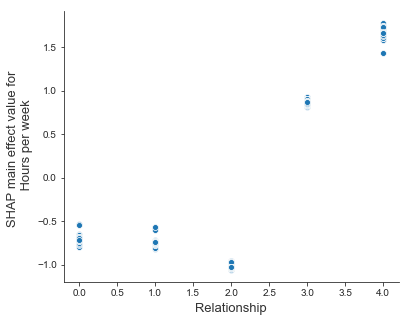

In [20]:
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.scatterplot(x=X_new['Relationship'].iloc[X_train.index].iloc[:8000], y=shap_interaction_values[:,4,4],
                 )
ax.set_xlabel('Relationship', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Hours per week', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Age

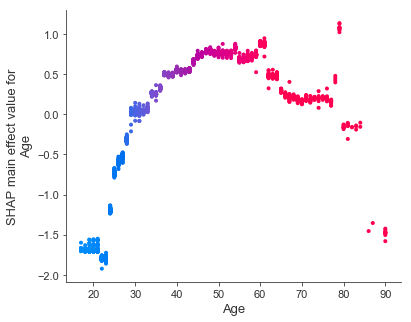

In [21]:
shap.dependence_plot(
    ("Age", "Age"), 
    shap_interaction_values, X_train.iloc[:8000,:], 
)

{'polynomial': [0.0463661903964685, -1.7839902680708193], 'determination': 0.5564468344451734}
{'polynomial': [-0.002226987537380319, 0.2360396297529817, -5.369798218103404], 'determination': 0.9299282315488236}
{'polynomial': [2.386987073007381e-05, -0.0055288544057419614, 0.37559845188344115, -7.144919186438717], 'determination': 0.9461586583096334}
{'polynomial': [-5.35316540737436e-08, 3.428908388131987e-05, -0.006238548058644459, 0.39547840158779024, -7.336479060200258], 'determination': 0.946190285389004}
{'polynomial': [-4.304504652330393e-09, 9.066254053500302e-07, -4.455801424140591e-05, -0.003300022041960543, 0.3465988239788779, -7.051288421540977], 'determination': 0.947360571664592}


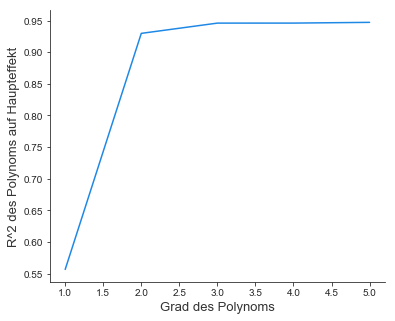

In [22]:
x_poly = X_train['Age'].iloc[:8000]
y_poly = shap_interaction_values[:,0,0]
r_squared = []
for i in [1,2,3,4,5]: 
    print(poly_fit(x_poly, y_poly,i))
    r_squared.append(poly_fit(x_poly, y_poly,i)['determination'])
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x=[1,2,3,4,5], y=r_squared,
                 color = "#1E88E5")
ax.set_xlabel('Grad des Polynoms', color="#333333", fontsize=13)
ax.set_ylabel('R^2 des Polynoms auf Haupteffekt', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

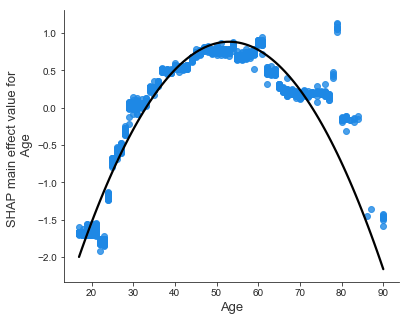

In [23]:
x_poly = X_train['Age'].iloc[:8000]
y_poly = shap_interaction_values[:,0,0]
z_poly = np.polyfit(x_poly, y_poly, 2)
poly_Age = np.poly1d(z_poly)
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.regplot(x=x_poly, y=y_poly,
                 order=2, ci=False, truncate=True, color = "#1E88E5", line_kws={'color': 'black'} )
ax.set_xlabel('Age', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Age', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [24]:
X_new['Age'] = poly_Age(X['Age'])
X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship',
                                                        'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')


____________One-Hot-Encoding____________
Logistische Regression: 0.9092167401002827 (0.003171332976485549)
Entscheid.baum(Tiefe4): 0.870037675575363 (0.0038753286964942862)
Grad. Boosted Machine : 0.927637370171911 (0.0018349091407373133)
_____________Value-Encoding_____________
Logistische Regression: 0.8956794209434227 (0.003741659672239639)
Entscheid.baum(Tiefe4): 0.870630112167573 (0.004030035820297517)
Grad. Boosted Machine : 0.9272088767059096 (0.0017986596443236617)


### Capital Gain

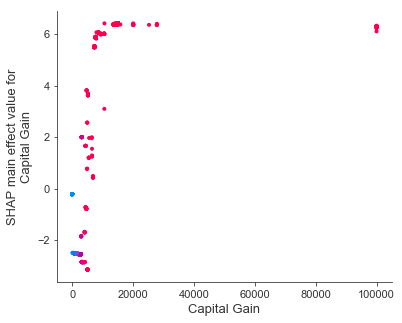

In [25]:
shap.dependence_plot(
    ("Capital Gain", "Capital Gain"), 
    shap_interaction_values, X_train.iloc[:8000,:], 
)

In [26]:
X_new['Capital Gain'] = pd.cut(X['Capital Gain'], bins=[0,4200,7500,120000], include_lowest=True, 
                               labels=['niedrig', 'mittel', 'hoch'])
X_new['Capital Gain'] = X_new['Capital Gain'].astype('category').cat.codes
X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                        'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.912545360396843 (0.002726341330290408)
Entscheid.baum(Tiefe4): 0.868234660168478 (0.0043481215621303075)
Grad. Boosted Machine : 0.9208849288732299 (0.002515550047416277)
_____________Value-Encoding_____________
Logistische Regression: 0.8987877837888307 (0.003526319817313466)
Entscheid.baum(Tiefe4): 0.8684869768434291 (0.004610407417731996)
Grad. Boosted Machine : 0.9203565458043471 (0.0022607708293837727)


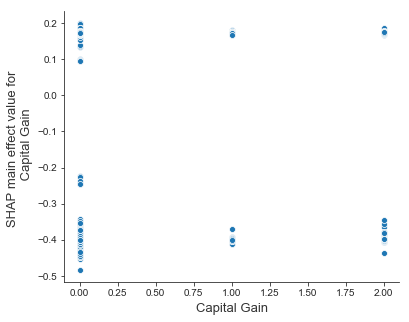

In [27]:

plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.scatterplot(x=X_new['Capital Gain'].iloc[X_train.index].iloc[:8000], y=shap_interaction_values[:,5,5],
                 )
ax.set_xlabel('Capital Gain', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Capital Gain', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Education-Num

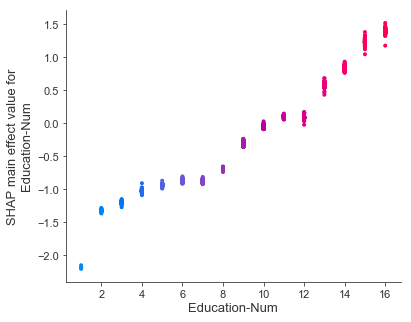

In [28]:
shap.dependence_plot(
    ("Education-Num", "Education-Num"), 
    shap_interaction_values, X_train.iloc[:8000,:], 
)

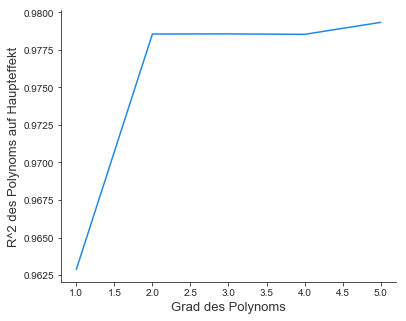

In [29]:
x_poly = X_train['Education-Num'].iloc[:8000]
y_poly = shap_interaction_values[:,1,1]
r_squared = []
for i in [1,2,3,4,5]: 
    r_squared.append(poly_fit(x_poly, y_poly,i)['determination'])
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x=[1,2,3,4,5], y=r_squared,
                 color = "#1E88E5")
ax.set_xlabel('Grad des Polynoms', color="#333333", fontsize=13)
ax.set_ylabel('R^2 des Polynoms auf Haupteffekt', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

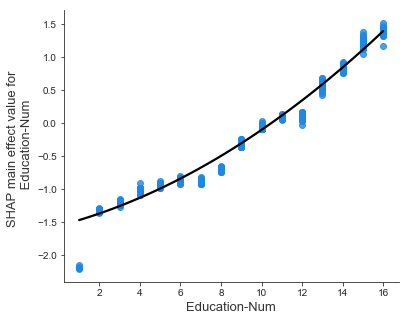

In [30]:
x_poly = X_train['Education-Num'].iloc[:8000]
y_poly = shap_interaction_values[:,1,1]
z_poly = np.polyfit(x_poly, y_poly, 2)
poly_Education_Num = np.poly1d(z_poly)
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.regplot(x=x_poly, y=y_poly,
                 order=2, ci=False, truncate=True, color = "#1E88E5", line_kws={'color': 'black'} )
ax.set_xlabel('Education-Num', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Education-Num', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Occupation

In [31]:
X_new['Education-Num'] = poly_Education_Num(X['Education-Num'])
X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                        'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')


____________One-Hot-Encoding____________
Logistische Regression: 0.9126073064599416 (0.002677800705257553)
Entscheid.baum(Tiefe4): 0.868234660168478 (0.0043481215621303075)
Grad. Boosted Machine : 0.9208849288732299 (0.002515550047416277)
_____________Value-Encoding_____________
Logistische Regression: 0.8989498972410616 (0.003408705439390205)
Entscheid.baum(Tiefe4): 0.8684869768434291 (0.004610407417731996)
Grad. Boosted Machine : 0.9203565458043471 (0.0022607708293837727)


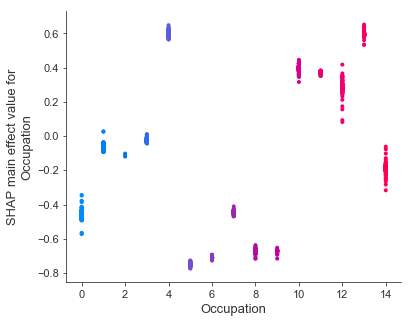

In [32]:
shap.dependence_plot(
    ("Occupation", "Occupation"), 
    shap_interaction_values, X_train.iloc[:8000,:], 
)

In [33]:
X_new['Occupation'] = np.where(
    X['Occupation']==0,'?', np.where(
        X['Occupation']<3,'Armee & Glauben', np.where(
            X['Occupation']==3,'Handwerk', np.where(
                X['Occupation']==4,'Technik', np.where(
                    X['Occupation']<7,'low-skilled', np.where(
                        X['Occupation']==7,'Fließbandarbeiter',np.where(
                            X['Occupation']<10,'low-skilled',np.where(
                                X['Occupation']<13,'Dienstleistung',np.where(
                                    X['Occupation']==13,'Technik','Transport')))))))))                                                                        


X_new['Occupation'] = X_new['Occupation'].astype('category').cat.codes
X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9124571153491001 (0.0027304276372895676)
Entscheid.baum(Tiefe4): 0.868234660168478 (0.0043481215621303075)
Grad. Boosted Machine : 0.9210388267922976 (0.002565882430320047)
_____________Value-Encoding_____________
Logistische Regression: 0.8993071330150164 (0.0035650276149826357)
Entscheid.baum(Tiefe4): 0.8684869768434291 (0.004610407417731996)
Grad. Boosted Machine : 0.9203175217811683 (0.00239916026190762)


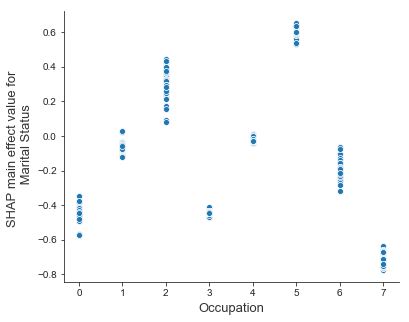

In [34]:
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.scatterplot(x=X_new['Occupation'].iloc[X_train.index].iloc[:8000], y=shap_interaction_values[:,3,3],
                 )
ax.set_xlabel('Occupation', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Marital Status', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Hours per week

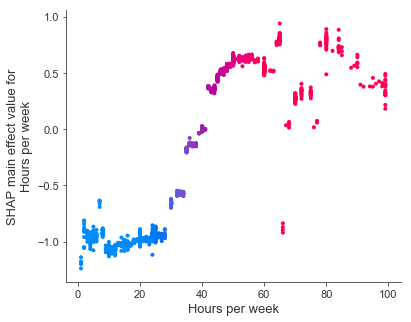

In [35]:
shap.dependence_plot(
    ("Hours per week", "Hours per week"), 
    shap_interaction_values, X_train.iloc[:8000,:], 
)

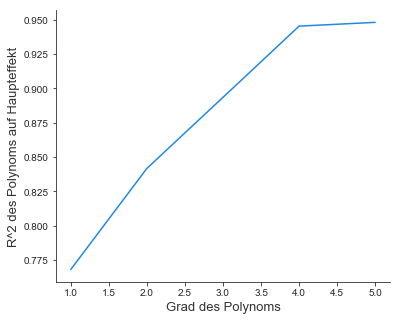

In [36]:
x_poly = X_train['Hours per week'].iloc[:8000]
y_poly = shap_interaction_values[:,8,8]
r_squared = []
for i in [1,2,3,4,5]: 
    r_squared.append(poly_fit(x_poly, y_poly,i)['determination'])
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x=[1,2,3,4,5], y=r_squared,
                 color = "#1E88E5")
ax.set_xlabel('Grad des Polynoms', color="#333333", fontsize=13)
ax.set_ylabel('R^2 des Polynoms auf Haupteffekt', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

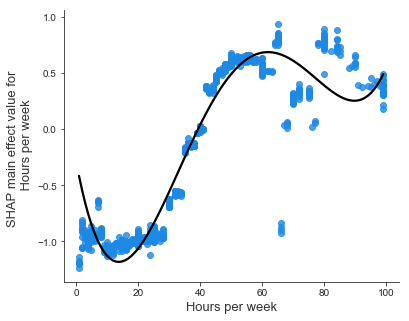

In [37]:
x_poly = X_train['Hours per week'].iloc[:8000]
y_poly = shap_interaction_values[:,8,8]
z_poly = np.polyfit(x_poly, y_poly, 4)
poly_Hours_per_week = np.poly1d(z_poly)
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.regplot(x=x_poly, y=y_poly,
                 order=4, ci=False, truncate=True, color = "#1E88E5", line_kws={'color': 'black'} )
ax.set_xlabel('Hours per week', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Hours per week', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [38]:
X_new['Hours per week'] = poly_Hours_per_week(X['Hours per week'])
X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')


____________One-Hot-Encoding____________
Logistische Regression: 0.9137152842341866 (0.0027538177055639592)
Entscheid.baum(Tiefe4): 0.8682353665780014 (0.004349430108077967)
Grad. Boosted Machine : 0.9208360637982477 (0.0023672610738678986)
_____________Value-Encoding_____________
Logistische Regression: 0.9011528927334682 (0.0035289300816941536)
Entscheid.baum(Tiefe4): 0.8684869768434291 (0.004610407417731996)
Grad. Boosted Machine : 0.9202770988292593 (0.0024121080395716732)


### Marital Status

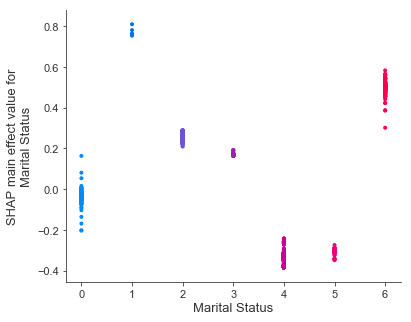

In [39]:
shap.dependence_plot(
    ("Marital Status", "Marital Status"), 
    shap_interaction_values, X_train.iloc[:8000,:], 
)

In [40]:
X_new['Marital Status'] = X['Marital Status']
#X_new['Marital Status'] = pd.cut(X['Marital Status'], bins=[-1,0,1,3,5,7,120], include_lowest=True, 
#                                labels=['allein', 'verwandt', 'verwandt_1','verheiratet_2', 'verheiratet_0','verheiratet'])
X_new['Marital Status'] = X_new['Marital Status'].astype('category').cat.codes
X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9137152842341866 (0.0027538177055639592)
Entscheid.baum(Tiefe4): 0.8682353665780014 (0.004349430108077967)
Grad. Boosted Machine : 0.9208360637982477 (0.0023672610738678986)
_____________Value-Encoding_____________
Logistische Regression: 0.9011528927334682 (0.0035289300816941536)
Entscheid.baum(Tiefe4): 0.8684869768434291 (0.004610407417731996)
Grad. Boosted Machine : 0.9202770988292593 (0.0024121080395716732)


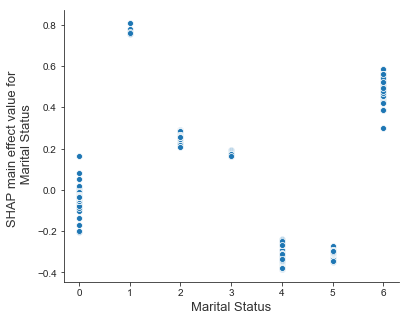

In [41]:
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.scatterplot(x=X_new['Marital Status'].iloc[X_train.index].iloc[:8000], y=shap_interaction_values[:,2,2],
                 )
ax.set_xlabel('Marital Status', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Marital Status', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Capital Loss

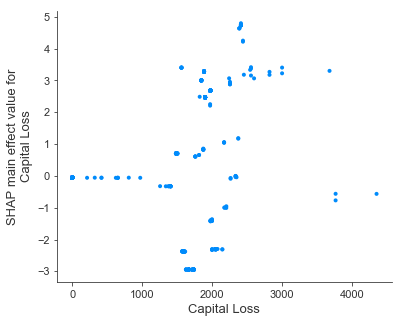

In [42]:
shap.dependence_plot(
    ("Capital Loss", "Capital Loss"), 
    shap_interaction_values, X_train.iloc[:8000,:], 
)

In [43]:
X_new['Capital Loss'] = pd.cut(X['Capital Loss'], bins=[0,1500,2400,3700,120000], include_lowest=True, 
                               labels=['low', 'medium','high', 'very high'])
X_new['Capital Loss'] = X_new['Capital Loss'].astype('category').cat.codes
X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Capital Loss', 'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9140420772560567 (0.0029872633924906957)
Entscheid.baum(Tiefe4): 0.8680142851431937 (0.0043720944396881175)
Grad. Boosted Machine : 0.914497366832378 (0.0026859492267216154)
_____________Value-Encoding_____________
Logistische Regression: 0.9012691738231527 (0.0036631501064054977)
Entscheid.baum(Tiefe4): 0.8726890780093749 (0.0035515430451871595)
Grad. Boosted Machine : 0.914104708860901 (0.0026099601905258513)


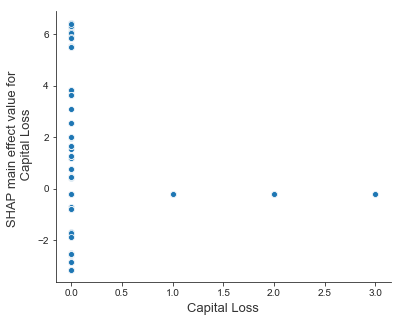

In [44]:
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.scatterplot(x=X_new['Capital Loss'].iloc[X_train.index].iloc[:8000], y=shap_interaction_values[:,6,6],
                 )
ax.set_xlabel('Capital Loss', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Capital Loss', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Zusammenfassung der Veränderung der mittleren Performance der k=5 CV

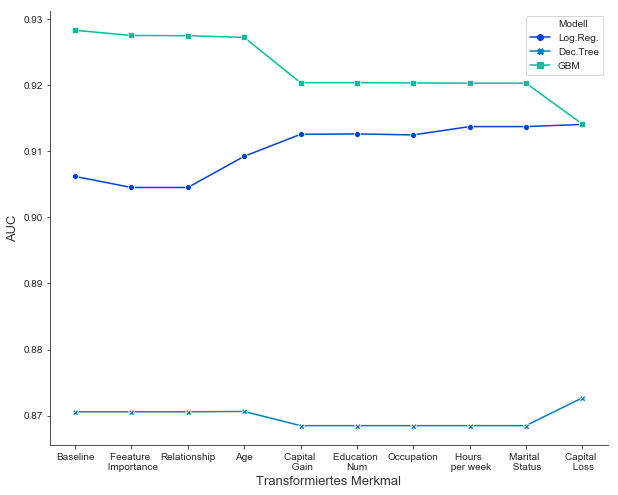

In [279]:
log_reg_auc = [0.906180220829242,0.9045061803896527,0.9045042986302332, 0.9092167401002827, 0.912545360396843,
              0.9126073064599416,0.9124571153491001, 0.9137152842341866, 0.9137152842341866,0.9140420772560567]
dec_tree_auc = [0.8705855305278174,0.8705855305278174,0.8705855305278174, 0.870630112167573, 0.8684869768434291,
               0.8684869768434291,0.8684869768434291,0.8684869768434291, 0.8684869768434291,0.8726890780093749]
gbm_auc = [0.9282809880653955,0.9274990356634069,0.9274608725184695, 0.9272088767059096, 0.9203565458043471,
          0.9203565458043471,0.9203175217811683, 0.9202770988292593, 0.9202770988292593,0.914104708860901] 
x_ax = ['Baseline', 'Feeature \n Importance', 'Relationship', 'Age', 'Capital \n Gain', 'Education \nNum', 'Occupation',
       'Hours \n per week', 'Marital \n Status', 'Capital \n Loss']

data_plot_performance = pd.DataFrame({'lines': log_reg_auc + dec_tree_auc + gbm_auc,
                                      'x_axe' :x_ax+x_ax+x_ax,
                                      'Modell': list(np.repeat(['Log.Reg.'],10))+list(np.repeat(['Dec.Tree'],10))+ list(np.repeat(['GBM'],10))
                                     })
plt.figure(figsize=(10,8), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x='x_axe', y='lines', data=data_plot_performance, hue = 'Modell', style='Modell',
                  markers=True, dashes=False,palette='winter', sort=False
                  )
ax.set_xlabel('Transformiertes Merkmal', color="#333333", fontsize=13)
ax.set_ylabel('Performance des Modells (AUC)', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


## III. Integration von Interaktionen anhand von SHAP
Es folgt das Integrieren von Interaktionen zwischen Merkmalen. Dazu werden *SHAP Interaction Plots* erzeugt. Daraus lassen sich, in Abhängigkeit vom Merkmalstyp, geschickte Transformationen ableiten. Die Interaktionen werden anhand der Stärke des Interaktionseffekts der Gradient Boosting Machine in der folgenden Heatmap erzeugt und in die White-Box-Modelle integriert. 

<function matplotlib.pyplot.show(*args, **kw)>

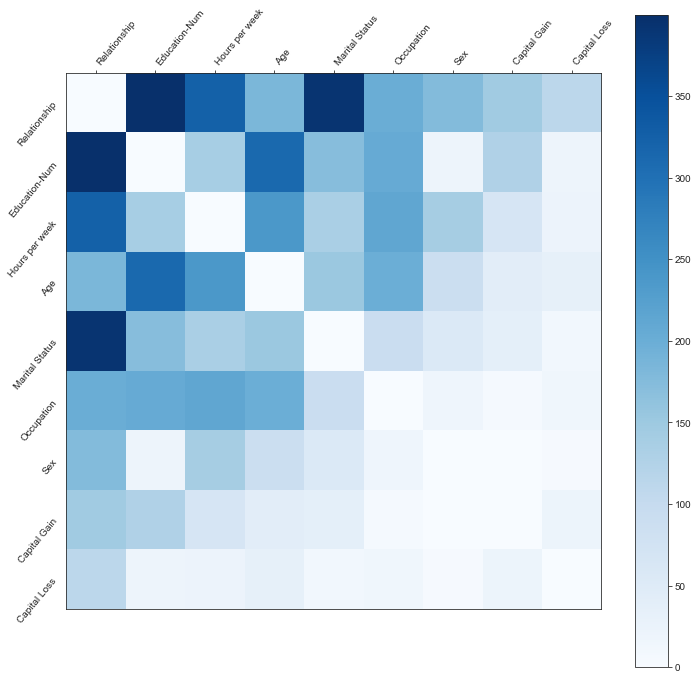

In [46]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2,cmap="Blues")
pl.yticks(range(tmp2.shape[0]), X_train.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X_train.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.colorbar()
pl.show

#### Interaktion zwischen Relationship und Education-Num

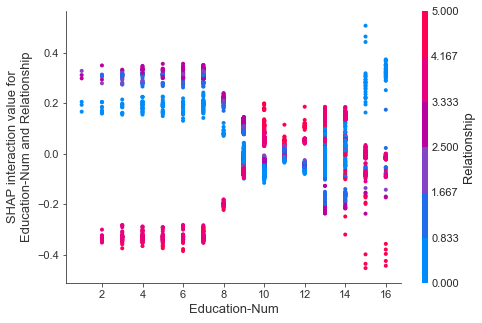

In [48]:
shap.dependence_plot(
    ("Education-Num", "Relationship"),
    shap_interaction_values, X_train.iloc[:8000,:], 
)

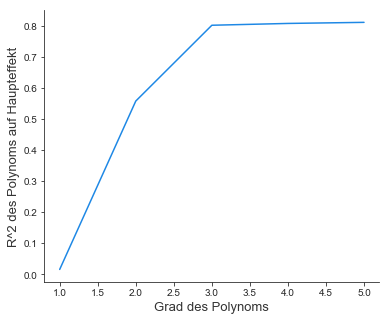

In [49]:
shap_interaction_Rel_Edu = pd.DataFrame(shap_interaction_values[:,4,1],index = X_train.iloc[:8000,:].index)
interaction = pd.concat([X_train.iloc[:8000,:],shap_interaction_Rel_Edu],axis=1)
interaction = interaction.rename(columns={0:'interact'})
interaction = interaction[interaction['Relationship']==0][['Education-Num','Relationship', 'interact']]
x_poly = interaction['Education-Num']
y_poly = interaction['interact']
r_squared = []
for i in [1,2,3,4,5]: 
    r_squared.append(poly_fit(x_poly, y_poly,i)['determination'])
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x=[1,2,3,4,5], y=r_squared,
                 color = "#1E88E5")
ax.set_xlabel('Grad des Polynoms', color="#333333", fontsize=13)
ax.set_ylabel('R^2 des Polynoms auf Haupteffekt', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


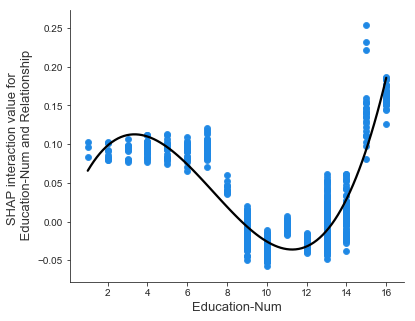

In [50]:
z_poly = np.polyfit(x_poly, y_poly, 3)
poly_inter_Edu_Rel_0 = np.poly1d(z_poly)

plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.scatterplot(x=x_poly, y=y_poly,color = "#1E88E5")
ax = sns.regplot(x=x_poly, y=y_poly,
                 order=3, ci=False, truncate=True, color = "#1E88E5", line_kws={'color': 'black'} )
ax.set_xlabel('Education-Num', color="#333333", fontsize=13)
ax.set_ylabel('SHAP interaction value for \n Education-Num and Relationship', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [51]:
X_new['inter_Rel_Edu_0'] = np.where(X['Relationship']==0,
                                  poly_inter_Edu_Rel_0(X['Education-Num']),0)

X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Capital Loss', 'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9141129599717275 (0.002943628147299035)
Entscheid.baum(Tiefe4): 0.8680181484638517 (0.004369897162711416)
Grad. Boosted Machine : 0.914491772571749 (0.002673646050749879)
_____________Value-Encoding_____________
Logistische Regression: 0.9013052902305663 (0.003623370678509372)
Entscheid.baum(Tiefe4): 0.8726953998068154 (0.0035581162492020345)
Grad. Boosted Machine : 0.9139770859809133 (0.002686197675287607)


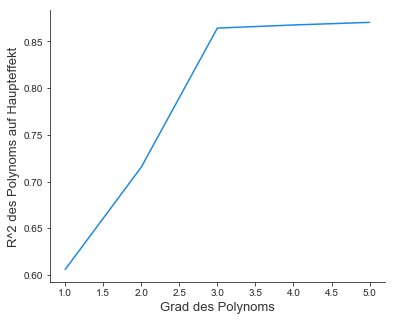

In [52]:
shap_interaction_Rel_Edu = pd.DataFrame(shap_interaction_values[:,4,1],index = X_train.iloc[:8000,:].index)
interaction = pd.concat([X_train.iloc[:8000,:],shap_interaction_Rel_Edu],axis=1)
interaction = interaction.rename(columns={0:'interact'})
interaction = interaction[interaction['Relationship']>3][['Education-Num','interact']]
x_poly = interaction['Education-Num']
y_poly = interaction['interact']
r_squared = []
for i in [1,2,3,4,5]: 
    r_squared.append(poly_fit(x_poly, y_poly,i)['determination'])
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x=[1,2,3,4,5], y=r_squared,
                 color = "#1E88E5")
ax.set_xlabel('Grad des Polynoms', color="#333333", fontsize=13)
ax.set_ylabel('R^2 des Polynoms auf Haupteffekt', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

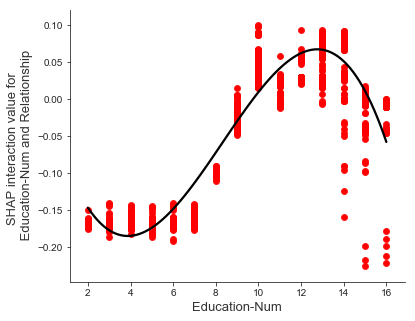

In [53]:
z_poly = np.polyfit(x_poly, y_poly, 3)
poly_inter_Edu_Rel_4_5 = np.poly1d(z_poly)
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.scatterplot(x=x_poly, y=y_poly,color = "red")
ax = sns.regplot(x=x_poly, y=y_poly,
                 order=3, ci=False, truncate=True, color = "red", line_kws={'color': 'black'} )
ax.set_xlabel('Education-Num', color="#333333", fontsize=13)
ax.set_ylabel('SHAP interaction value for \n Education-Num and Relationship', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [54]:

X_new['inter_Rel_Edu_45'] = np.where(X['Relationship']>3,
                                  poly_inter_Edu_Rel_4_5(X['Education-Num']),0)
X_new['inter_Rel_Edu_0'] = np.where(X['Relationship']==0,
                                  poly_inter_Edu_Rel_0(X['Education-Num']),0)

X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Capital Loss', 'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9141626128615933 (0.00294432025714481)
Entscheid.baum(Tiefe4): 0.8709929208038142 (0.0031225028776251775)
Grad. Boosted Machine : 0.9146574956618763 (0.002977478256210886)
_____________Value-Encoding_____________
Logistische Regression: 0.9014382514368429 (0.003635195217723637)
Entscheid.baum(Tiefe4): 0.8709122459848707 (0.003077474450332274)
Grad. Boosted Machine : 0.914033305519063 (0.002835253549502153)


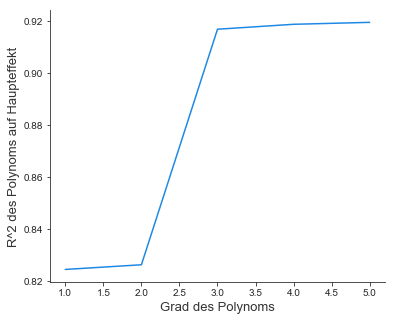

In [55]:
shap_interaction_Rel_Edu = pd.DataFrame(shap_interaction_values[:,4,1],index = X_train.iloc[:8000,:].index)
interaction = pd.concat([X_train.iloc[:8000,:],shap_interaction_Rel_Edu],axis=1)
interaction = interaction.rename(columns={0:'interact'})
interaction = interaction[(interaction['Relationship']>0) & (interaction['Relationship']<4)][['Education-Num','interact']]
x_poly = interaction['Education-Num']
y_poly = interaction['interact']
r_squared = []
for i in [1,2,3,4,5]: 
    r_squared.append(poly_fit(x_poly, y_poly,i)['determination'])
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x=[1,2,3,4,5], y=r_squared,
                 color = "#1E88E5")
ax.set_xlabel('Grad des Polynoms', color="#333333", fontsize=13)
ax.set_ylabel('R^2 des Polynoms auf Haupteffekt', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

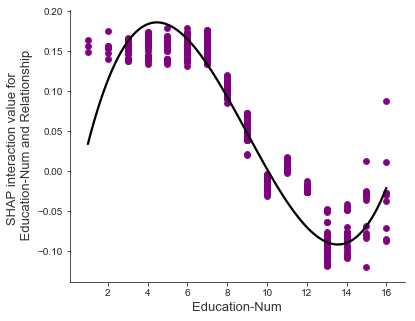

In [56]:
z_poly = np.polyfit(x_poly, y_poly, 3)
poly_inter_Edu_Rel_123 = np.poly1d(z_poly)
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.scatterplot(x=x_poly, y=y_poly,color = "purple")
ax = sns.regplot(x=x_poly, y=y_poly,
                 order=3, ci=False, truncate=True, color = "purple", line_kws={'color': 'black'} )
ax.set_xlabel('Education-Num', color="#333333", fontsize=13)
ax.set_ylabel('SHAP interaction value for \n Education-Num and Relationship', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [57]:

X_new['inter_Rel_Edu_123'] = np.where(X['Relationship'] == 0,0,np.where(X['Relationship']>3,
                                  0,poly_inter_Edu_Rel_123(X['Education-Num'])))

X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Capital Loss', 'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9141637924547075 (0.0029366679851974583)
Entscheid.baum(Tiefe4): 0.8709929208038142 (0.0031225028776251775)
Grad. Boosted Machine : 0.9146522301772994 (0.0030236802362292614)
_____________Value-Encoding_____________
Logistische Regression: 0.901695660384515 (0.0035942957120948106)
Entscheid.baum(Tiefe4): 0.8709122459848707 (0.003077474450332274)
Grad. Boosted Machine : 0.91379382171821 (0.002757961060289794)


#### Interaktion zwischen Relationship und Hours per week

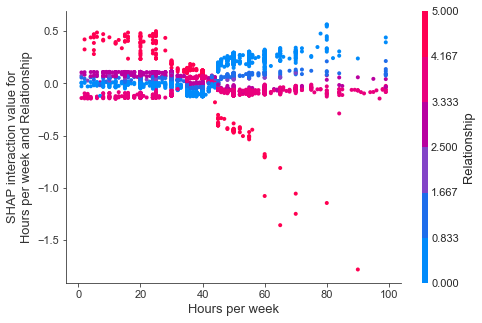

In [58]:
shap.dependence_plot(
    ("Hours per week", "Relationship"),
    shap_interaction_values, X_train.iloc[:8000,:], 
)

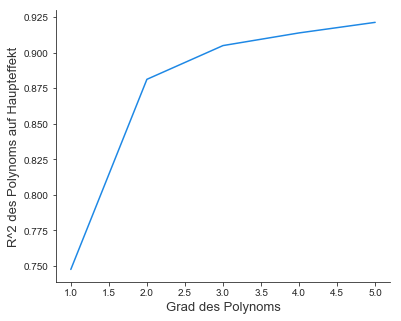

In [59]:
shap_interaction_Rel_HpW = pd.DataFrame(shap_interaction_values[:,4,8],index = X_train.iloc[:8000,:].index)
interaction = pd.concat([X_train.iloc[:8000,:],shap_interaction_Rel_HpW],axis=1)
interaction = interaction.rename(columns={0:'interact'})
interaction = interaction[interaction['Relationship']==5][['Hours per week','interact']]
x_poly = interaction['Hours per week']
y_poly = interaction['interact']
r_squared = []
for i in [1,2,3,4,5]: 
    r_squared.append(poly_fit(x_poly, y_poly,i)['determination'])
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x=[1,2,3,4,5], y=r_squared,
                 color = "#1E88E5")
ax.set_xlabel('Grad des Polynoms', color="#333333", fontsize=13)
ax.set_ylabel('R^2 des Polynoms auf Haupteffekt', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


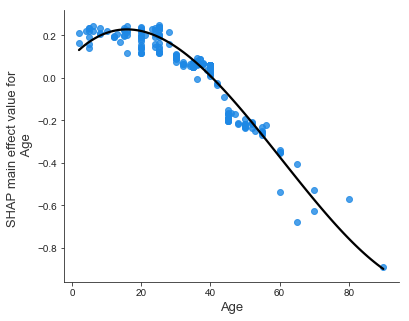

In [60]:
z_poly = np.polyfit(x_poly, y_poly, 3)
poly_inter_HpW_Rel_5 = np.poly1d(z_poly)
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.regplot(x=x_poly, y=y_poly,
                 order=3, ci=False, truncate=True, color = "#1E88E5", line_kws={'color': 'black'} )
ax.set_xlabel('Age', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Age', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [61]:
X_new['inter_Rel_HpW_5'] = np.where(X['Relationship'] == 5,poly_inter_HpW_Rel_5(X['Hours per week']),0)

X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Capital Loss', 'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9145128531386393 (0.002915161319842197)
Entscheid.baum(Tiefe4): 0.8709929208038142 (0.0031225028776251775)
Grad. Boosted Machine : 0.9142700610579485 (0.0028766335058779693)
_____________Value-Encoding_____________
Logistische Regression: 0.9022483547716155 (0.003510074645509558)
Entscheid.baum(Tiefe4): 0.8709122459848707 (0.003077474450332274)
Grad. Boosted Machine : 0.913548494055156 (0.0029174082780236855)


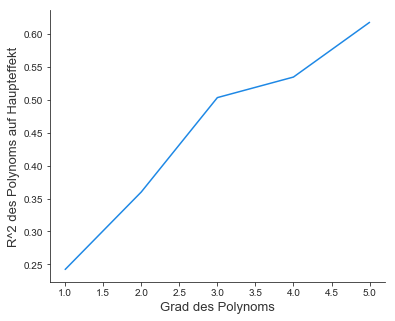

In [62]:
shap_interaction_Rel_HpW = pd.DataFrame(shap_interaction_values[:,4,8],index = X_train.iloc[:8000,:].index)
interaction = pd.concat([X_train.iloc[:8000,:],shap_interaction_Rel_HpW],axis=1)
interaction = interaction.rename(columns={0:'interact'})
interaction = interaction[(interaction['Relationship']<3)][['Hours per week','interact']]
x_poly = interaction['Hours per week']
y_poly = interaction['interact']
r_squared = []
for i in [1,2,3,4,5]: 
    r_squared.append(poly_fit(x_poly, y_poly,i)['determination'])
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x=[1,2,3,4,5], y=r_squared,
                 color = "#1E88E5")
ax.set_xlabel('Grad des Polynoms', color="#333333", fontsize=13)
ax.set_ylabel('R^2 des Polynoms auf Haupteffekt', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

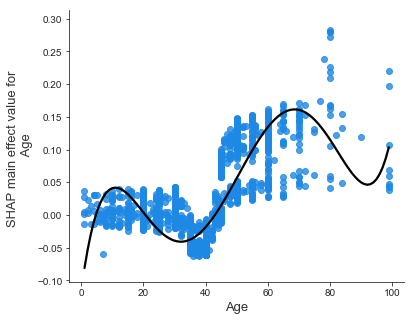

In [63]:
z_poly = np.polyfit(x_poly, y_poly, 5)
poly_inter_HpW_Rel_012 = np.poly1d(z_poly)
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.regplot(x=x_poly, y=y_poly,
                 order=5, ci=False, truncate=True, color = "#1E88E5", line_kws={'color': 'black'} )
ax.set_xlabel('Age', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Age', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [64]:
X_new['inter_Rel_HpW_012'] = np.where(X['Relationship'] <3,poly_inter_HpW_Rel_012(X['Hours per week']),0)

X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Capital Loss', 'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9146027800666537 (0.0029403516914176474)
Entscheid.baum(Tiefe4): 0.8697135494122333 (0.004417041705667007)
Grad. Boosted Machine : 0.9140790678833486 (0.0029460145825975486)
_____________Value-Encoding_____________
Logistische Regression: 0.9026233973204991 (0.00366951029472385)
Entscheid.baum(Tiefe4): 0.8696328745932898 (0.004381958284533615)
Grad. Boosted Machine : 0.913411924189796 (0.0030170831894041667)


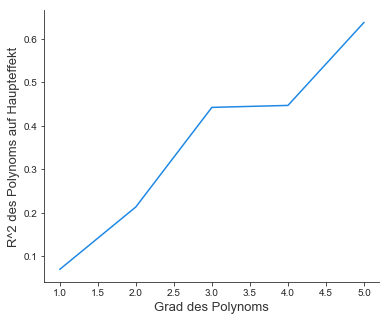

In [65]:
shap_interaction_Rel_HpW = pd.DataFrame(shap_interaction_values[:,4,8],index = X_train.iloc[:8000,:].index)
interaction = pd.concat([X_train.iloc[:8000,:],shap_interaction_Rel_HpW],axis=1)
interaction = interaction.rename(columns={0:'interact'})
interaction = interaction[interaction['Relationship']==4][['Hours per week','interact']]
x_poly = interaction['Hours per week']
y_poly = interaction['interact']
r_squared = []
for i in [1,2,3,4,5]: 
    r_squared.append(poly_fit(x_poly, y_poly,i)['determination'])
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x=[1,2,3,4,5], y=r_squared,
                 color = "#1E88E5")
ax.set_xlabel('Grad des Polynoms', color="#333333", fontsize=13)
ax.set_ylabel('R^2 des Polynoms auf Haupteffekt', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

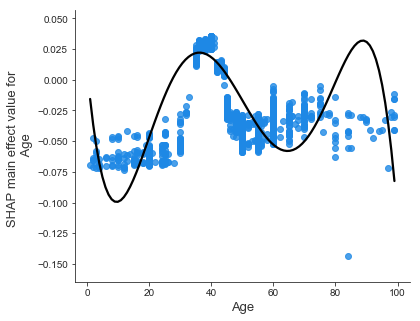

In [66]:
z_poly = np.polyfit(x_poly, y_poly, 5)
poly_inter_HpW_Rel_4 = np.poly1d(z_poly)
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.regplot(x=x_poly, y=y_poly,
                 order=5, ci=False, truncate=True, color = "#1E88E5", line_kws={'color': 'black'} )
ax.set_xlabel('Age', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Age', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [67]:
X_new['inter_Rel_HpW_4'] = np.where(X['Relationship'] ==4,poly_inter_HpW_Rel_4(X['Hours per week']),0)

X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Capital Loss', 'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9148065007471262 (0.0028573757214636966)
Entscheid.baum(Tiefe4): 0.8697135494122333 (0.004417041705667007)
Grad. Boosted Machine : 0.9141172088921806 (0.002929022027667735)
_____________Value-Encoding_____________
Logistische Regression: 0.9028474136458498 (0.00358601261506973)
Entscheid.baum(Tiefe4): 0.8696328745932898 (0.004381958284533615)
Grad. Boosted Machine : 0.9130621122785119 (0.0029783497112207406)


#### Interaktion zwischen Age und Education-Num

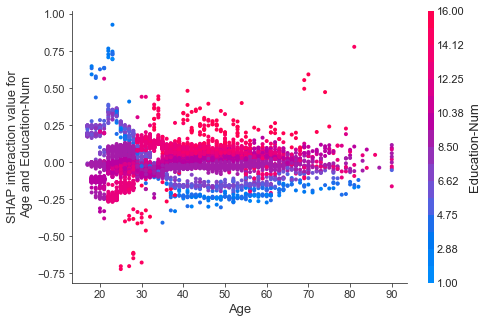

In [68]:
shap.dependence_plot(
    ("Age", "Education-Num"),
    shap_interaction_values, X_train.iloc[:8000,:], 
)

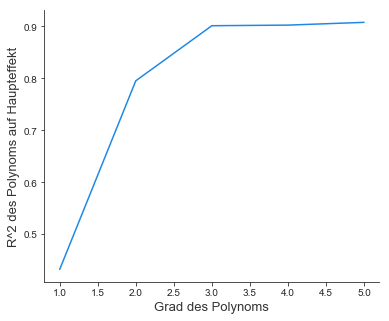

In [69]:
shap_interaction_Edu_Age = pd.DataFrame(shap_interaction_values[:,0,1],index = X_train.iloc[:8000,:].index)
interaction = pd.concat([X_train.iloc[:8000,:],shap_interaction_Edu_Age],axis=1)
interaction = interaction.rename(columns={0:'interact'})
interaction = interaction[interaction['Education-Num']<5][['Age','interact']]
x_poly = interaction['Age']
y_poly = interaction['interact']
r_squared = []
for i in [1,2,3,4,5]: 
    r_squared.append(poly_fit(x_poly, y_poly,i)['determination'])
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x=[1,2,3,4,5], y=r_squared,
                 color = "#1E88E5")
ax.set_xlabel('Grad des Polynoms', color="#333333", fontsize=13)
ax.set_ylabel('R^2 des Polynoms auf Haupteffekt', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


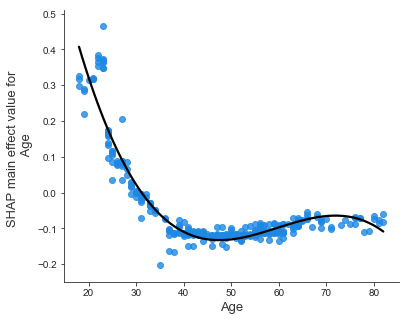

In [70]:
z_poly = np.polyfit(x_poly, y_poly, 3)
poly_inter_Age_Edu_0_4 = np.poly1d(z_poly)
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.regplot(x=x_poly, y=y_poly,
                 order=3, ci=False, truncate=True, color = "#1E88E5", line_kws={'color': 'black'} )
ax.set_xlabel('Age', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Age', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [71]:
X_new['inter_Age_Edu_0_4'] = np.where(X['Education-Num']<5,poly_inter_Age_Edu_0_4(X['Age']),0)

X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Capital Loss', 'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9148165012738725 (0.0028634938293008575)
Entscheid.baum(Tiefe4): 0.8697135494122333 (0.004417041705667007)
Grad. Boosted Machine : 0.9139045733820998 (0.0029946734605822783)
_____________Value-Encoding_____________
Logistische Regression: 0.9028387654581891 (0.0036080000225461872)
Entscheid.baum(Tiefe4): 0.8696328745932898 (0.004381958284533615)
Grad. Boosted Machine : 0.9129180343550999 (0.003060355683470734)


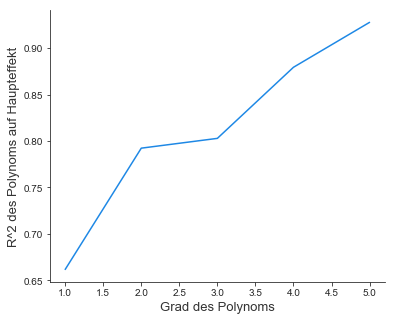

In [72]:
shap_interaction_Edu_Age = pd.DataFrame(shap_interaction_values[:,0,1],index = X_train.iloc[:8000,:].index)
interaction = pd.concat([X_train.iloc[:8000,:],shap_interaction_Edu_Age],axis=1)
interaction = interaction.rename(columns={0:'interact'})
interaction = interaction[(interaction['Education-Num']<9)& (interaction['Education-Num']>4)][['Age','interact']]
x_poly = interaction['Age']
y_poly = interaction['interact']
r_squared = []
for i in [1,2,3,4,5]: 
    r_squared.append(poly_fit(x_poly, y_poly,i)['determination'])
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x=[1,2,3,4,5], y=r_squared,
                 color = "#1E88E5")
ax.set_xlabel('Grad des Polynoms', color="#333333", fontsize=13)
ax.set_ylabel('R^2 des Polynoms auf Haupteffekt', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

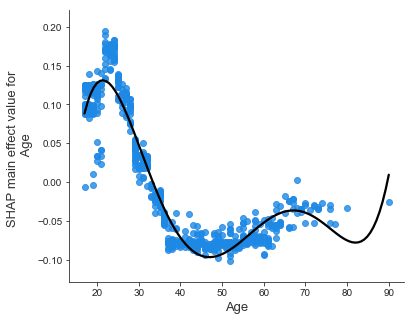

In [73]:
z_poly = np.polyfit(x_poly, y_poly, 5)
poly_inter_5_8 = np.poly1d(z_poly)
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.regplot(x=x_poly, y=y_poly,
                 order=5, ci=False, truncate=True, color = "#1E88E5", line_kws={'color': 'black'} )
ax.set_xlabel('Age', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Age', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [74]:
X_new['inter_Age_Edu_5_8'] = np.where(X['Education-Num']<5,0,np.where(X['Education-Num']>8,0,
                                                                      poly_inter_Age_Edu_0_4(X['Age'])))

X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Capital Loss', 'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9148260226933775 (0.0028482052417356436)
Entscheid.baum(Tiefe4): 0.8697135494122333 (0.004417041705667007)
Grad. Boosted Machine : 0.9137805997246062 (0.003160665417105694)
_____________Value-Encoding_____________
Logistische Regression: 0.9028337806229579 (0.003603142747630691)
Entscheid.baum(Tiefe4): 0.8696328745932898 (0.004381958284533615)
Grad. Boosted Machine : 0.9128726774377492 (0.003085915186164712)


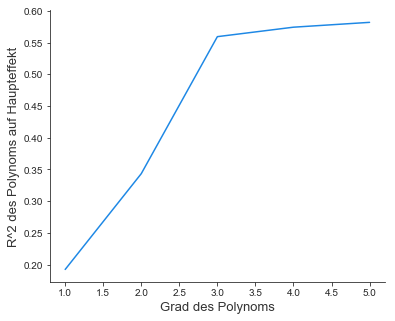

In [75]:
shap_interaction_Edu_Age = pd.DataFrame(shap_interaction_values[:,0,1],index = X_train.iloc[:8000,:].index)
interaction = pd.concat([X_train.iloc[:8000,:],shap_interaction_Edu_Age],axis=1)
interaction = interaction.rename(columns={0:'interact'})
interaction = interaction[(interaction['Education-Num']>14)][['Age','interact']]
x_poly = interaction['Age']
y_poly = interaction['interact']
r_squared = []
for i in [1,2,3,4,5]: 
    r_squared.append(poly_fit(x_poly, y_poly,i)['determination'])
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x=[1,2,3,4,5], y=r_squared,
                 color = "#1E88E5")
ax.set_xlabel('Grad des Polynoms', color="#333333", fontsize=13)
ax.set_ylabel('R^2 des Polynoms auf Haupteffekt', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

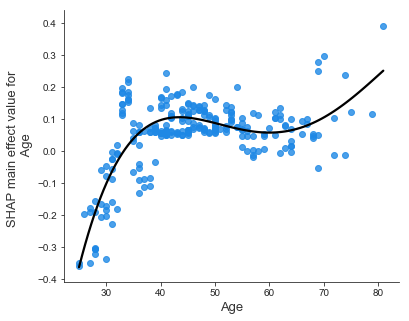

In [76]:
z_poly = np.polyfit(x_poly, y_poly, 4)
poly_inter_15_16 = np.poly1d(z_poly)
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.regplot(x=x_poly, y=y_poly,
                 order=4, ci=False, truncate=True, color = "#1E88E5", line_kws={'color': 'black'} )
ax.set_xlabel('Age', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Age', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [77]:
X_new['inter_Age_Edu_15_16'] = np.where(X['Education-Num']>14,poly_inter_15_16(X['Age']),0)

X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Capital Loss', 'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9148711184371866 (0.0028498329242812284)
Entscheid.baum(Tiefe4): 0.8677348573473415 (0.0064788420270352485)
Grad. Boosted Machine : 0.9138644687626915 (0.0028860429786546266)
_____________Value-Encoding_____________
Logistische Regression: 0.9028412239693404 (0.003601231400841363)
Entscheid.baum(Tiefe4): 0.8676577501337761 (0.0064424555093233775)
Grad. Boosted Machine : 0.9128055788330988 (0.003068503365424356)


#### Interaktion zwischen Age und Hours per week

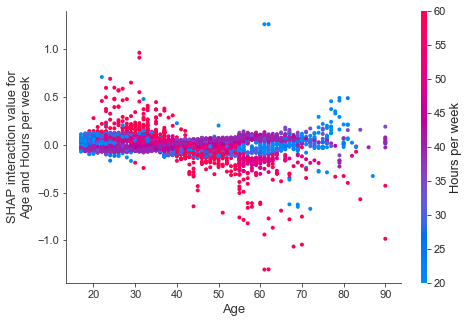

In [78]:

shap.dependence_plot(
    ("Age", "Hours per week"),
    shap_interaction_values, X_train.iloc[:8000,:], 
)

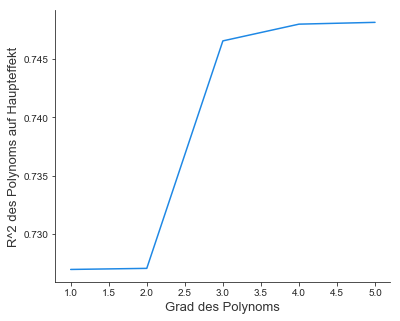

In [79]:
shap_interaction_HpW_Age = pd.DataFrame(shap_interaction_values[:,0,8],index = X_train.iloc[:8000,:].index)
interaction = pd.concat([X_train.iloc[:8000,:],shap_interaction_HpW_Age],axis=1)
interaction = interaction.rename(columns={0:'interact'})
interaction = interaction[interaction['Hours per week']>60][['Age','interact']]
x_poly = interaction['Age']
y_poly = interaction['interact']
r_squared = []
for i in [1,2,3,4,5]: 
    r_squared.append(poly_fit(x_poly, y_poly,i)['determination'])
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x=[1,2,3,4,5], y=r_squared,
                 color = "#1E88E5")
ax.set_xlabel('Grad des Polynoms', color="#333333", fontsize=13)
ax.set_ylabel('R^2 des Polynoms auf Haupteffekt', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


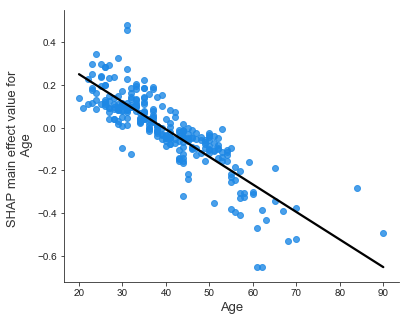

In [80]:
z_poly = np.polyfit(x_poly, y_poly, 1)
poly_inter_Age_HwP_60 = np.poly1d(z_poly)
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.regplot(x=x_poly, y=y_poly,
                 order=1, ci=False, truncate=True, color = "#1E88E5", line_kws={'color': 'black'} )
ax.set_xlabel('Age', color="#333333", fontsize=13)
ax.set_ylabel('SHAP main effect value for \n Age', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [81]:
X_new['inter_Age_HwP_60'] = np.where(X['Hours per week']>60,poly_inter_Age_HwP_60(X['Age']),0)

X_one_hot_new = pd.get_dummies(X_new, prefix_sep='_',columns = ['Occupation','Relationship','Capital Gain',
                                                                'Capital Loss', 'Marital Status'])
result_log_reg = comp_result(logreg,X_one_hot_new,y )
result_dec_tree = comp_result(dec_tree,X_one_hot_new,y )
result_gbm = comp_result(clf,X_one_hot_new,y )
print('____________One-Hot-Encoding____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')
result_log_reg = comp_result(logreg,X_new,y )
result_dec_tree = comp_result(dec_tree,X_new,y )
result_gbm = comp_result(clf,X_new,y )
print('_____________Value-Encoding_____________')
print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Entscheid.baum(Tiefe4): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')

____________One-Hot-Encoding____________
Logistische Regression: 0.9149856135758849 (0.0028749493297448134)
Entscheid.baum(Tiefe4): 0.8677348573473415 (0.0064788420270352485)
Grad. Boosted Machine : 0.9134446233531369 (0.002759469696016575)
_____________Value-Encoding_____________
Logistische Regression: 0.9029764335129549 (0.0036161950554203215)
Entscheid.baum(Tiefe4): 0.8676577501337761 (0.0064424555093233775)
Grad. Boosted Machine : 0.9127431300812138 (0.0029987947612762906)


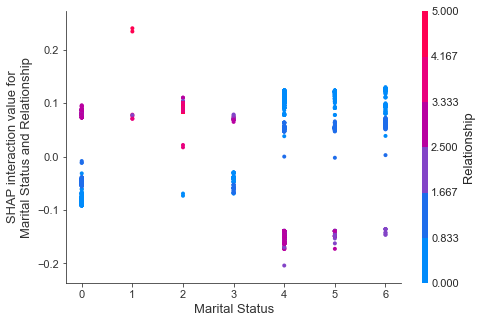

In [82]:
shap.dependence_plot(
    ("Marital Status", "Relationship"),
    shap_interaction_values, X_train.iloc[:8000,:], 
)

### Zusammenfassung der Integration von Interaktionen

Es fällt auf, dass die Performancegewinne bei den White-Box-Modellen eher gering sind. Dies hat mit der - in Vergleich zu den Haupteffekten - geringen Stärke der Interaktionseffekte zu tun, wie die folgende Heatmap illustriert. 

<function matplotlib.pyplot.show(*args, **kw)>

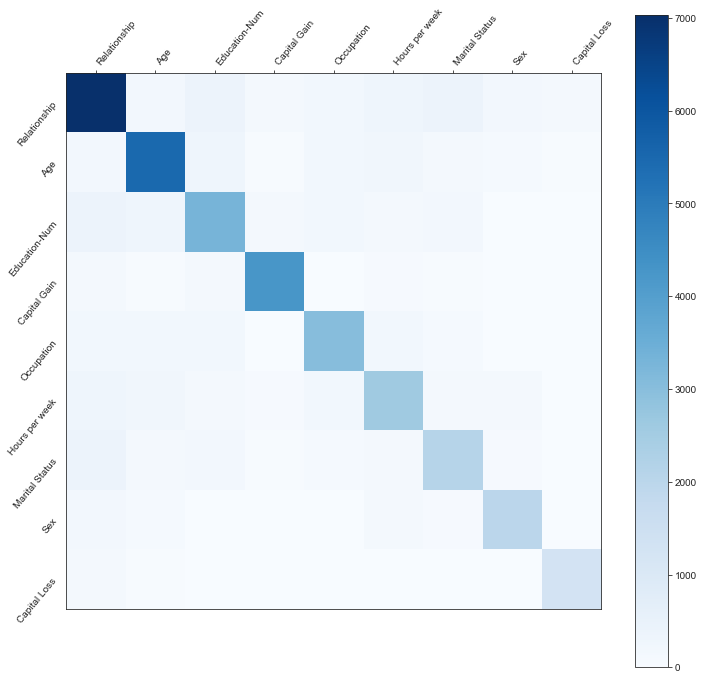

In [83]:
tmp = np.abs(shap_interaction_values).sum(0)

inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2,cmap="Blues")
pl.yticks(range(tmp2.shape[0]), X_train.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X_train.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.colorbar()
pl.show

## IV. Evaluation von Methodik 1
In der Grafik ind die Boxplots einer fünffach durchgeführten k=5 CV der drei Originalmodelle *Ent.baum, Log.Reg. (base)* und *Grad. Boost*, sowie des besten White-Box-Modells nach Anwendung von Methodik 1 (*Log. Reg. (adv)* zu sehen. 
Es wird auch die statistische Signifikanz der Verbesserung der logistischen Regression, sowie die nachwievor vorhandene statistische signifikante Differenz zwischen bestem White- und Black-Box-Modell untersucht. 

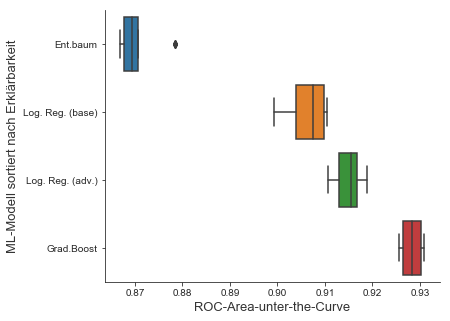

In [265]:
result_log_reg = []
result_dec_tree = []
result_gbm = []
result_log_reg_base = []
for seeds in [0,1,2,3,4]: 
    result_log_reg.append(comp_result(logreg,X_one_hot_new,y, seed=seeds ))
    result_dec_tree.append(comp_result(dec_tree,X,y, seed=seeds ))
    result_gbm.append(comp_result(clf,X,y, seed=seeds ))
    result_log_reg_base.append(comp_result(logreg,X_one_hot,y, seed=seeds ))

data = [ result_dec_tree,result_log_reg_base,result_log_reg, result_gbm]
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.boxplot(x=data,y=['Ent.baum','Log. Reg. (base)','Log. Reg. (adv.)', 'Grad.Boost']
                )
ax.set_xlabel('ROC-Area-unter-the-Curve', color="#333333", fontsize=13)
ax.set_ylabel('ML-Modell sortiert nach Erklärbarkeit', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


### 5x2CV Test zwischen Log. Reg. (advanced) und der GBM

In [84]:
test_log_reg = test_evaluation(logreg,X_one_hot_new,y)
test_gbm = test_evaluation(clf,X,y)
print(test_log_reg)
print(test_gbm)
scipy.stats.ttest_rel(test_log_reg[1],test_gbm[1])

(0.914755143345368, [0.9118431662369478, 0.9176028660484487, 0.9137835165431296, 0.9160071997914775, 0.9107547920199601, 0.9188244876638876, 0.9115020713596551, 0.9176547314318086, 0.9163170558803868, 0.9132615464779783])
(0.9268813237764257, [0.9232850146697092, 0.9301968830429779, 0.9254801756972904, 0.9272714548712255, 0.9241591448937007, 0.9306864317961523, 0.92279798806878, 0.9292300112939063, 0.9287425494612374, 0.9269635839692781])


Ttest_relResult(statistic=-43.84588367822399, pvalue=8.340903476809964e-12)

### 5x2CV Test zwischen Log. Reg. (advanced) und Log. Reg. (base)

In [85]:
test_log_reg = test_evaluation(logreg,X_one_hot_new,y)
test_gbm = test_evaluation(logreg,X_one_hot,y)
print(test_log_reg)
print(test_gbm)
scipy.stats.ttest_rel(test_log_reg[1],test_gbm[1])

(0.914755143345368, [0.9118431662369478, 0.9176028660484487, 0.9137835165431296, 0.9160071997914775, 0.9107547920199601, 0.9188244876638876, 0.9115020713596551, 0.9176547314318086, 0.9163170558803868, 0.9132615464779783])
(0.9047354658803535, [0.9016406695051156, 0.9068575123837608, 0.9052061706111432, 0.9050679422080024, 0.9009780371503995, 0.9094647032021029, 0.9019569032079249, 0.9078936564948537, 0.9024819030566884, 0.9058071609835435])


Ttest_relResult(statistic=18.85661079610147, pvalue=1.5250369579505673e-08)

## Methode 2: Feature Engineering anhand der Vorhersagedifferenz
Die zweite Methodik hingegen wählt einen anderen Ansatz, Merkmale anhand
des Black-Box-Modells zu generieren. Anstatt das Black-Box-Modell in
seiner Gesamtheit zu erklären und daraus Erkenntnisse über sinnvolle Transformationen
bzw. neue Feature abzuleiten, betrachtet dieser ausschließlich
die Beobachtungen, für die das Black-Box-Modell zu einer anderen Einschätzung
wie das White-Box-Modell gelangt.

### Trainieren der logistischen Regression (advanced) auf gleichem Train-Test-Split wie GBM

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
clf.fit(X_train,y_train)
X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(X_one_hot_new, y, test_size = 0.2, random_state=0)
logreg.fit(X_train_oh,y_train_oh)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [209]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.926036210147357

### Berechnen der Klassifikationsdifferenz

In [294]:
differenz = pd.concat([X_train, pd.DataFrame(logreg.predict_proba(X_train_oh)[:,1], index = X_train.index)], axis=1)
differenz = differenz.rename(columns={0:'log_probs'})
differenz = pd.concat([differenz, pd.DataFrame(clf.predict_proba(X_train)[:,1],index = differenz.index)], axis=1)
differenz = differenz.rename(columns={0:'gbm_probs'})
differenz = pd.concat([differenz, pd.DataFrame(y_train, index = differenz.index)], axis=1)
differenz = differenz.rename(columns={0:'target'})
differenz['Differenz'] = differenz['log_probs']-differenz['gbm_probs']
diff_groß = np.where(np.abs(differenz['Differenz']) > 0.2)
diff_klein = np.where(np.abs(differenz['Differenz']) < 0.2)


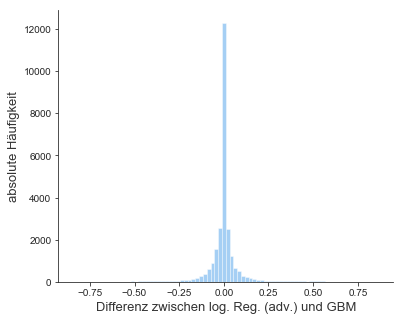

In [295]:
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.distplot(differenz['Differenz'],bins=80, kde=False,color = "#1E88E5")

ax.set_xlabel('Differenz zwischen log. Reg. (adv.) und GBM', color="#333333", fontsize=13)
ax.set_ylabel('absolute Häufigkeit', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Bestimmen des Schwellwertes

In [113]:
cutoff_normal = pd.DataFrame({'Cut-Off' : [],'Modell' : [],'AUC (große Diff)' : [],'AUC (kleine Diff)' : [],
                              'Anzahl Beobachtungen (groß)': [], 'Anzahl Beobachtungen (klein)': []})

for cutoff in np.arange(0.05, 0.55, 0.05):
    diff_groß_1 = np.where(np.abs(differenz['Differenz']) >= cutoff)
    diff_klein_1 = np.where(np.abs(differenz['Differenz']) < cutoff)
    for model in ['log_probs', 'gbm_probs']:
        perf_groß = roc_auc_score(differenz['target'].iloc[diff_groß_1], differenz[model].iloc[diff_groß_1])
        perf_klein = roc_auc_score(differenz['target'].iloc[diff_klein_1], differenz[model].iloc[diff_klein_1]) 
        dataframe = pd.DataFrame({'Cut-Off' : [cutoff],'Modell' : ['Log. Reg. (adv.)' if model =='log_probs' else 'GBM' ],'AUC (große Diff)' : [perf_groß],
                                  'AUC (kleine Diff)' : [perf_klein],
                                  'Anzahl Beobachtungen (groß)': differenz[model].iloc[diff_groß_1].shape[0],
                                  'Anzahl Beobachtungen (klein)': differenz[model].iloc[diff_klein_1].shape[0] })
        cutoff_normal = pd.concat([cutoff_normal, dataframe], ignore_index=True)
             


,Cut-Off,Modell,AUC (große Diff),AUC (kleine Diff),Anzahl Beobachtungen (groß),Anzahl Beobachtungen (klein)
0,0.05,Log. Reg. (adv.),0.743565,0.947834,6186.0,19862.0
1,0.05,GBM,0.877908,0.950211,6186.0,19862.0
2,0.10,Log. Reg. (adv.),0.656619,0.935594,2951.0,23097.0
3,0.10,GBM,0.916891,0.939509,2951.0,23097.0
4,0.15,Log. Reg. (adv.),0.563188,0.931110,1761.0,24287.0
5,0.15,GBM,0.951921,0.937083,1761.0,24287.0
6,0.20,Log. Reg. (adv.),0.473657,0.928750,1217.0,24831.0
7,0.20,GBM,0.973838,0.936439,1217.0,24831.0
8,0.25,Log. Reg. (adv.),0.363658,0.927278,879.0,25169.0
9,0.25,GBM,0.985373,0.936615,879.0,25169.0


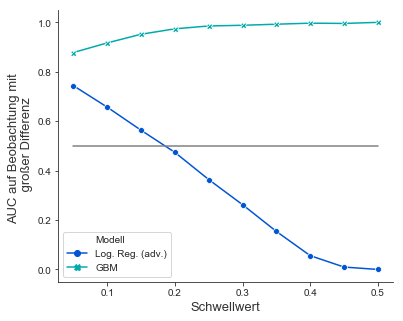

In [136]:
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x='Cut-Off', y='AUC (große Diff)', data=cutoff_normal, hue = 'Modell', style='Modell',
                  markers=True, dashes=False,palette='winter'
                  )
sns.lineplot(x=np.arange(0.05, 0.55, 0.05), y=[0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5] ,
                   linestyle='-.',color='grey' 
                  )
ax.set_xlabel('Schwellwert', color="#333333", fontsize=13)
ax.set_ylabel('AUC auf Beobachtung mit \n großer Differenz', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

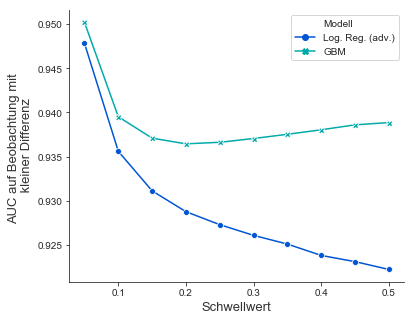

In [170]:
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.lineplot(x='Cut-Off', y='AUC (kleine Diff)', data=cutoff_normal, hue = 'Modell', style='Modell',
                  markers=True, dashes=False,palette='winter'
                  )
ax.set_xlabel('Schwellwert', color="#333333", fontsize=13)
ax.set_ylabel('AUC auf Beobachtung mit \n kleiner Differenz', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [296]:
log_all = roc_auc_score(differenz['target'].iloc[diff_groß], differenz['log_probs'].iloc[diff_groß])
clf_all = roc_auc_score(differenz['target'].iloc[diff_groß], differenz['gbm_probs'].iloc[diff_groß])
log_all_klein = roc_auc_score(differenz['target'].iloc[diff_klein], differenz['log_probs'].iloc[diff_klein])
clf_all_klein = roc_auc_score(differenz['target'].iloc[diff_klein], differenz['gbm_probs'].iloc[diff_klein])
log_full = roc_auc_score(differenz['target'], differenz['log_probs'])
clf_full = roc_auc_score(differenz['target'], differenz['gbm_probs'])
pd.DataFrame(np.array([[log_all, log_all_klein, log_full],[clf_all, clf_all_klein, clf_full],
                      [differenz.iloc[diff_groß].shape[0], differenz.iloc[diff_klein].shape[0], differenz.shape[0]]]),
             columns=['Große Differenz [>0.2]','Kleine Differenz [<=0.2]', 'Ganzer Datensatz'], 
            index=['Log. Regression', 'Gradient Boosted Machine', 'Anzahl Beobachtungen'])

,Große Differenz [>0.2],Kleine Differenz [<=0.2],Ganzer Datensatz
Log. Regression,0.489589,0.928250,0.915926
Gradient Boosted Machine,0.979411,0.936454,0.940176
Anzahl Beobachtungen,1254.000000,24794.000000,26048.000000


### Analyse der Feature Importance beider Modelle auf Großer bzw. Kleiner Differenz

In [212]:
explainer_groß = shap.TreeExplainer(clf)
shap_values_groß = explainer_groß.shap_values(X_train.iloc[diff_groß])
shap_interaction_values_groß = shap.TreeExplainer(clf).shap_interaction_values(X_train.iloc[diff_groß])

explainer_log_groß = shap.LinearExplainer(logreg, X_train_oh.iloc[diff_groß], feature_dependence='independent')
shap_values_log_groß = explainer_log_groß.shap_values(X_train_oh.iloc[diff_groß])

explainer_klein = shap.TreeExplainer(clf)
shap_values_klein = explainer_klein.shap_values(X_train.iloc[diff_klein])
shap_interaction_values_klein = shap.TreeExplainer(clf).shap_interaction_values(X_train.iloc[diff_klein])

explainer_log_klein = shap.LinearExplainer(logreg, X_train_oh.iloc[diff_klein], feature_dependence='independent')
shap_values_log_klein = explainer_log_klein.shap_values(X_train_oh.iloc[diff_klein])

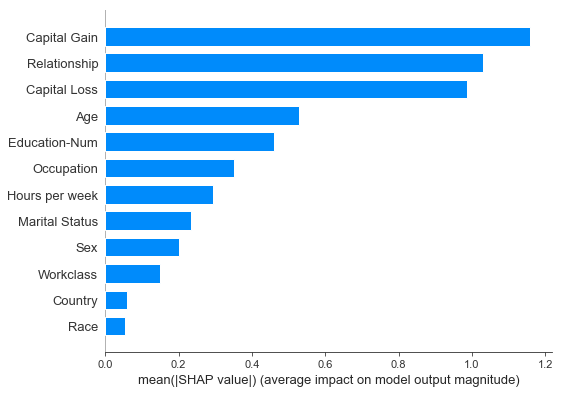

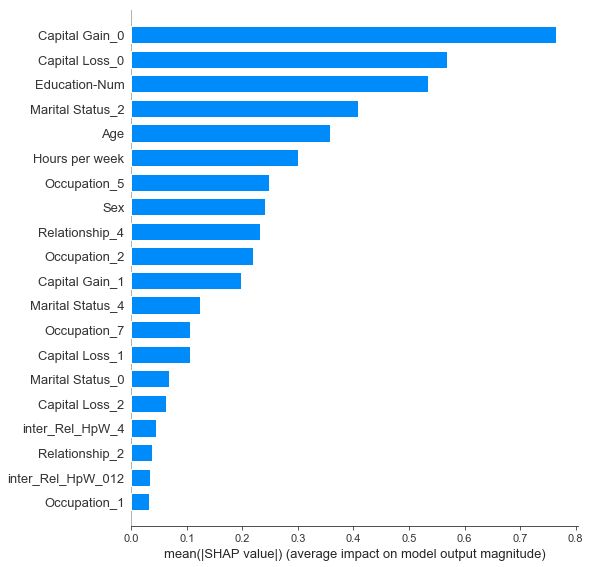

In [213]:
shap.summary_plot(shap_values_groß, X_train.iloc[diff_groß], plot_type="bar"
                 )

shap.summary_plot(shap_values_log_groß,X_train_oh.iloc[diff_groß], plot_type="bar"
                 )

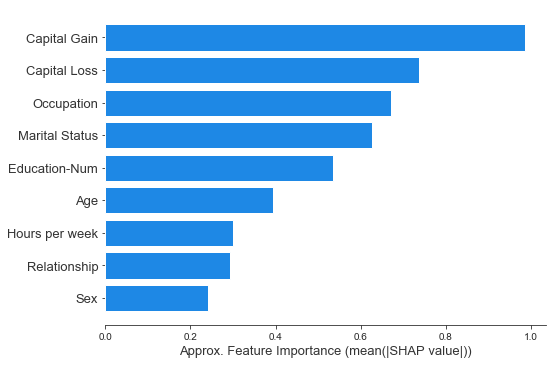

In [236]:
feature_importance = []
for i,feature in enumerate(list(X_n)): 
    idx = [list(X_train_oh).index(s) for s in list(X_train_oh) if feature in s]
    feature_importance.append(np.mean(np.abs(shap_values_log_groß[:,idx]).sum(axis=1)))
feature_importance = 100.0 * (feature_importance / max(feature_importance) *  max(feature_importance))
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig, ax = plt.subplots(figsize=(1.5 * 4.6 + 1, 0.8 * 6 + 1))
ax.barh(pos, feature_importance[sorted_idx]/100, align='center',color = "#1E88E5")
plt.yticks(pos, np.array(list(X_n))[sorted_idx],  color="#333333", fontsize=13)
ax.set_xlabel('Approx. Feature Importance (mean(|SHAP value|))', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.show()

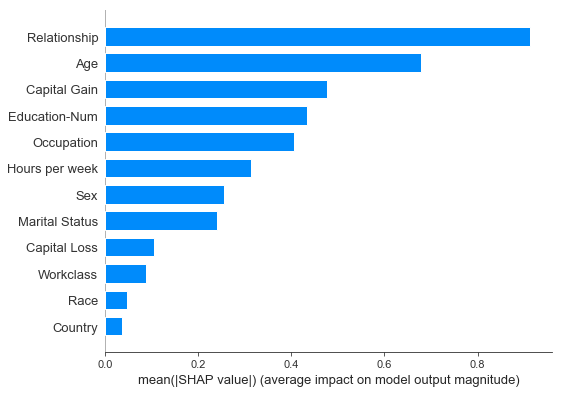

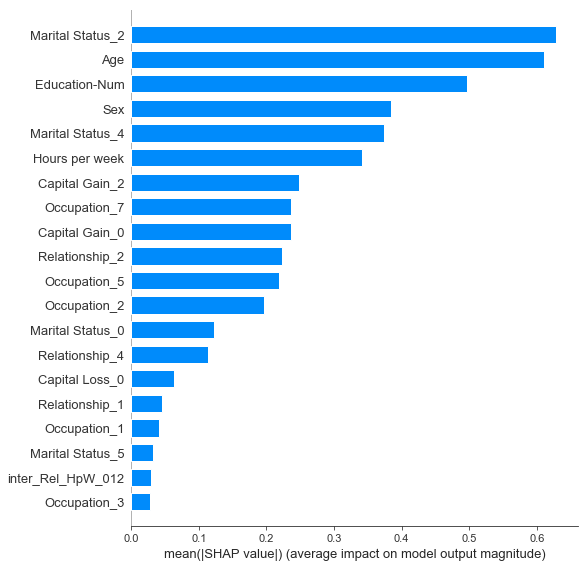

In [215]:
shap.summary_plot(shap_values_klein, X_train.iloc[diff_klein], plot_type="bar"
                 )

shap.summary_plot(shap_values_log_klein,X_train_oh.iloc[diff_klein], plot_type="bar"
                 )

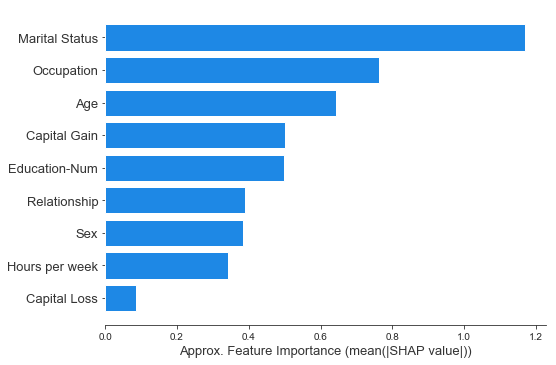

In [237]:
feature_importance = []
for i,feature in enumerate(list(X_n)): 
    idx = [list(X_train_oh).index(s) for s in list(X_train_oh) if feature in s]
    feature_importance.append(np.mean(np.abs(shap_values_log_klein[:,idx]).sum(axis=1)))
feature_importance = 100.0 * (feature_importance / max(feature_importance) *  max(feature_importance))
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig, ax = plt.subplots(figsize=(1.5 * 4.6 + 1, 0.8 * 6 + 1))
ax.barh(pos, feature_importance[sorted_idx]/100, align='center',color = "#1E88E5")
plt.yticks(pos, np.array(list(X_n))[sorted_idx],  color="#333333", fontsize=13)
ax.set_xlabel('Approx. Feature Importance (mean(|SHAP value|))', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.show()

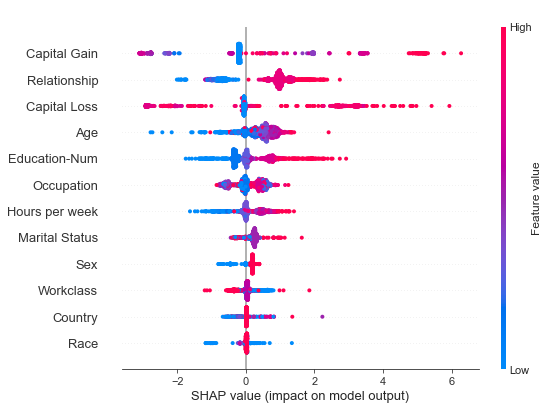

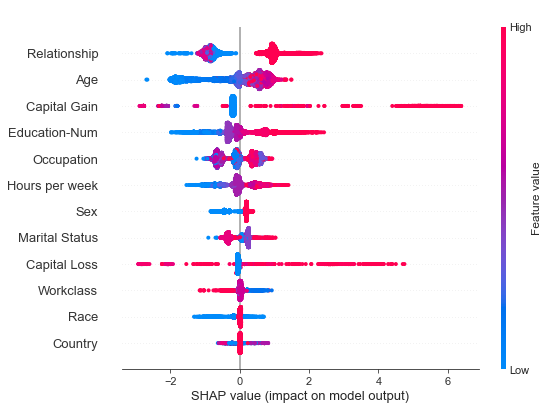

In [238]:
shap.summary_plot(shap_values_groß, X_train.iloc[diff_groß], 
                 )

shap.summary_plot(shap_values_klein, X_train.iloc[diff_klein], 
                 )

### Vergleich der Merkmalsverteilungen bei kleiner bzw. großer Vorhersagedifferenz

Anteil Capital Gain > 0 bei kleiner Differenz:0.06953295152052916
Anteil Capital Gain > 0 bei großer Differenz: 0.37161084529505584


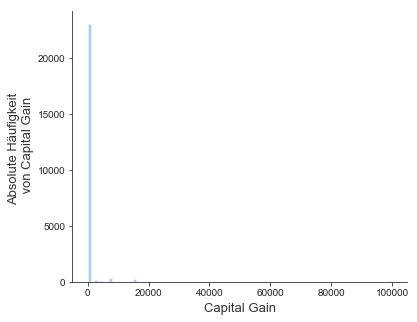

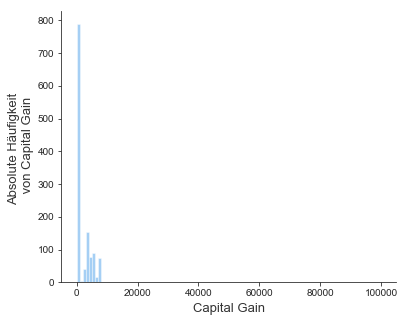

In [246]:
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.distplot( X_train['Capital Gain'].iloc[diff_klein],bins=100,color = "#1E88E5",kde=False )
ax.set_xlabel('Capital Gain', color="#333333", fontsize=13)
ax.set_ylabel('Absolute Häufigkeit \n von Capital Gain', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.distplot( X_train['Capital Gain'].iloc[diff_groß],bins=100,color = "#1E88E5",kde=False )
ax.set_xlabel('Capital Gain', color="#333333", fontsize=13)
ax.set_ylabel('Absolute Häufigkeit \n von Capital Gain', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print('Anteil Capital Gain > 0 bei kleiner Differenz:' + 
      str((X_train.iloc[diff_klein]['Capital Gain']>0).sum()/X_train.iloc[diff_klein]['Capital Gain'].shape[0]))
print('Anteil Capital Gain > 0 bei großer Differenz: ' + 
      str((X_train.iloc[diff_groß]['Capital Gain']>0).sum()/X_train.iloc[diff_groß]['Capital Gain'].shape[0]))

Anteil Capital Loss > 0 bei kleiner Differenz:0.0305719125594902
Anteil Capital Loss > 0 bei großer Differenz: 0.3668261562998405


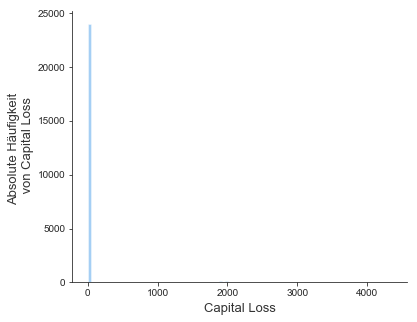

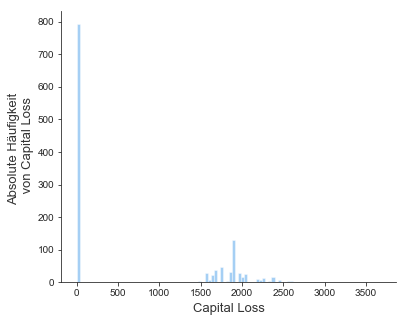

In [247]:
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.distplot( X_train['Capital Loss'].iloc[diff_klein],bins=100,color = "#1E88E5",kde=False )
ax.set_xlabel('Capital Loss', color="#333333", fontsize=13)
ax.set_ylabel('Absolute Häufigkeit \n von Capital Loss', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.distplot( X_train['Capital Loss'].iloc[diff_groß],bins=100,color = "#1E88E5",kde=False )
ax.set_xlabel('Capital Loss', color="#333333", fontsize=13)
ax.set_ylabel('Absolute Häufigkeit \n von Capital Loss', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print('Anteil Capital Loss > 0 bei kleiner Differenz:' + 
      str((X_train.iloc[diff_klein]['Capital Loss']>0).sum()/X_train.iloc[diff_klein]['Capital Loss'].shape[0]))
print('Anteil Capital Loss > 0 bei großer Differenz: ' + 
      str((X_train.iloc[diff_groß]['Capital Loss']>0).sum()/X_train.iloc[diff_groß]['Capital Loss'].shape[0]))

In [249]:
print('Anteil Relationship = 4 bei kleiner Differenz:' + 
      str((X_train.iloc[diff_klein]['Relationship']==4).sum()/X_train.iloc[diff_klein]['Relationship'].shape[0]))
print('Anteil Relationship = 4 bei großer Differenz: ' + 
      str((X_train.iloc[diff_groß]['Relationship']==4).sum()/X_train.iloc[diff_groß]['Relationship'].shape[0]))
print('Anteil Marital Status = 2 bei kleiner Differenz:' + 
      str((X_train.iloc[diff_klein]['Marital Status']==2).sum()/X_train.iloc[diff_klein]['Marital Status'].shape[0]))
print('Anteil Marital Status = 2 bei großer Differenz: ' + 
      str((X_train.iloc[diff_groß]['Marital Status']==2).sum()/X_train.iloc[diff_groß]['Marital Status'].shape[0]))

Anteil Relationship = 4 bei kleiner Differenz:0.39061869807211425
Anteil Relationship = 4 bei großer Differenz: 0.6874003189792663
Anteil Marital Status = 2 bei kleiner Differenz:0.4411954505122207
Anteil Marital Status = 2 bei großer Differenz: 0.7998405103668261


### Trainieren eines erklärbaren Entscheidungsbaum auf Daten mit großer Vorhersagedifferenz

In [224]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_train.iloc[diff_groß], y_train[diff_groß], test_size = 0.2, random_state=0)
tree_df = DecisionTreeClassifier(max_depth=4,random_state=7)
tree_df.fit(X_train_df,y_train_df)
tree_df_probs = tree_df.predict_proba(X_test_df)[:,1]
roc_auc_score(y_test_df, tree_df_probs)

0.8427109974424551

In [228]:
tree_df_probs = tree_df.predict_proba(X_train.iloc[diff_klein])[:,1]
roc_auc_score(y_train[diff_klein], tree_df_probs)

0.47376226028067664

In [229]:
tree_df_probs = tree_df.predict_proba(X_train)[:,1]
roc_auc_score(y_train, tree_df_probs)

0.5014448960495004

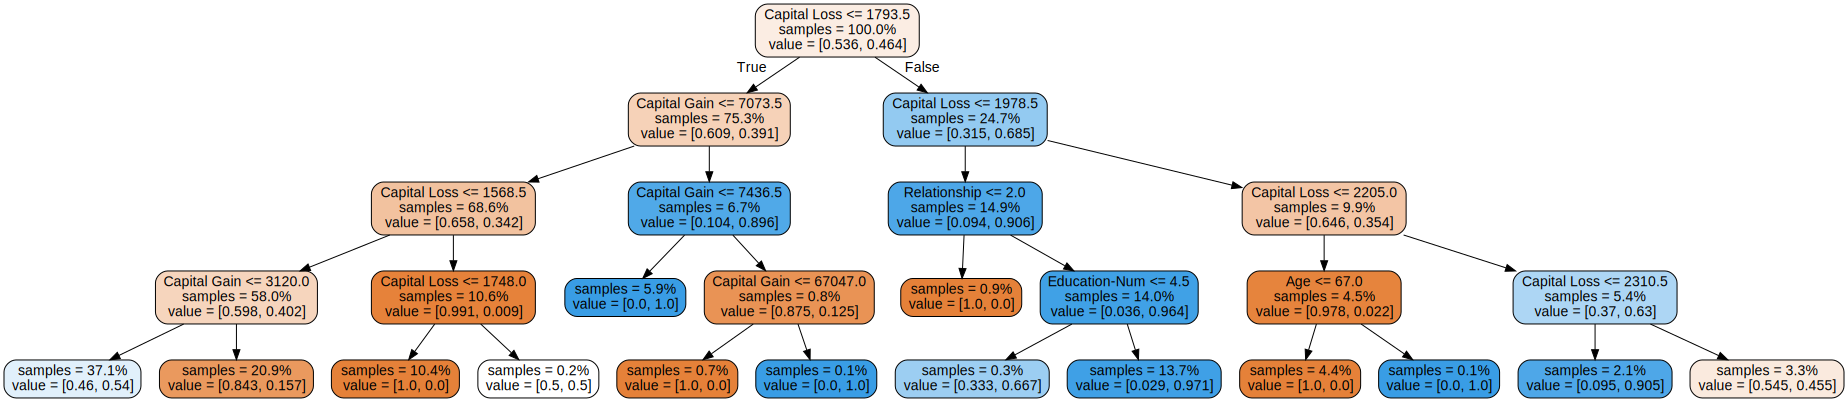

In [280]:
from sklearn import tree
from IPython.display import SVG 
from graphviz import Source 
from IPython.display import display 

graph = Source(tree.export_graphviz(tree_df, out_file=None, feature_names=X_train_df.columns.values.tolist(),
                                    proportion=True, filled=True, impurity=False, rounded=True))
graph.format = 'png'
graph.render('dtree_render',view=True)

display(SVG(graph.pipe(format='svg')))

### Extraktion von Merkmalen aus dem Entscheidungsbaum und Integration in log.Reg.(advanced)

In [301]:
X_log_reg_adv = X_one_hot_new.copy()
X_log_reg_adv['Feature_Dec_Tree_1'] = np.where(X['Capital Loss']>1793.5, 0,
                                               np.where(X['Capital Gain']<=7073.5,0,
                                                        np.where(X['Capital Gain']>7436.5, 0,1)))
X_log_reg_adv['Feature_Dec_Tree_2'] = np.where(X['Capital Loss']>1793.5, 0,
                                               np.where(X['Capital Gain']>7073.5,0,
                                                        np.where(X['Capital Loss']<1568.5, 0,1)))
X_log_reg_adv['Feature_Dec_Tree_3'] = np.where(X['Capital Loss']<=1793.5, 0,
                                               np.where(X['Capital Loss']>1978.5,0,1))
X_log_reg_adv['Feature_Dec_Tree_4'] = np.where(X['Capital Loss']<=1978.5, 0,
                                               np.where(X['Capital Loss']>2205.5,0,1))
X_log_reg_adv['Feature_Dec_Tree_5'] = np.where(X['Capital Gain']<=3120, 0,
                                               np.where(X['Capital Loss']>2568.5,0,1))
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_log_reg_adv, y, test_size = 0.2, random_state=0)
log_reg_advanced = LogisticRegression()
log_reg_advanced.fit(X_train_new, y_train_new)
print('GBM:' + str(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))
print('LR (advanced):' + str(roc_auc_score(y_test, logreg.predict_proba(X_test_oh)[:,1])))
print('LR (pluplus):' + str(roc_auc_score(y_test, log_reg_advanced.predict_proba(X_test_new)[:,1])))


GBM:0.926036210147357
LR (advanced):0.9135153826835334
LR (pluplus):0.9188048892112781


In [297]:
differenz = pd.concat([differenz, pd.DataFrame(log_reg_advanced.predict_proba(X_train_new)[:,1],index = differenz.index)], axis=1)
differenz = differenz.rename(columns={0:'log_reg_advanced'})
log_reg_advanced_all = roc_auc_score(differenz['target'].iloc[diff_groß], differenz['log_reg_advanced'].iloc[diff_groß])
log_reg_advanced_klein = roc_auc_score(differenz['target'].iloc[diff_klein], differenz['log_reg_advanced'].iloc[diff_klein])
log_reg_advanced_full = roc_auc_score(differenz['target'], differenz['log_reg_advanced'])
pd.DataFrame(np.array([[log_all, log_all_klein, log_full],[clf_all, clf_all_klein, clf_full],[log_reg_advanced_all, log_reg_advanced_klein, log_reg_advanced_full],
                      [differenz.iloc[diff_groß].shape[0], differenz.iloc[diff_klein].shape[0], differenz.shape[0]]]),
             columns=['Große Differenz [>0.2]','Kleine Differenz [<=0.2]', 'Ganzer Datensatz'], 
            index=['Log. Regression (advanced)', 'Gradient Boosted Machine','Logistische Regression (Dec.Tree)', 'Anzahl Beobachtungen'])

,Große Differenz [>0.2],Kleine Differenz [<=0.2],Ganzer Datensatz
Log. Regression (advanced),0.489589,0.928250,0.915926
Gradient Boosted Machine,0.979411,0.936454,0.940176
Logistische Regression (Dec.Tree),0.768199,0.928068,0.922691
Anzahl Beobachtungen,1254.000000,24794.000000,26048.000000


### Evaluation von Methodik 2
In der Grafik ind die Boxplots einer fünffach durchgeführten k=5 CV der drei Originalmodelle *Ent.baum, Log.Reg. (base)* und *Grad. Boost*, sowie des besten White-Box-Modells nach Anwendung von Methodik 1 (*Log. Reg. (adv)*) und Methodik 2 (*Log. Reg. (plusplus)*) zu sehen. 
Es wird auch die statistische Signifikanz der Verbesserung der logistischen Regression, sowie die nachwievor vorhandene statistische signifikante Differenz zwischen bestem White- und Black-Box-Modell untersucht. 

In [298]:
result_log_reg = comp_result(logreg,X_one_hot,y)
result_dec_tree = comp_result(logreg,X_one_hot_new,y)
result_log_reg_plus = comp_result(logreg,X_log_reg_adv,y)
result_gbm = comp_result(clf,X,y )



print('Logistische Regression: ' + str(result_log_reg.mean()) + ' (' + str(np.std(result_log_reg))+')')
print('Logistische Regression (advanced): ' + str(result_dec_tree.mean()) + ' (' + str(np.std(result_dec_tree))+')')
print('Logistische Regression (plusplus): ' + str(result_log_reg_plus.mean()) + ' (' + str(np.std(result_log_reg_plus))+')')
print('Grad. Boosted Machine : ' + str(result_gbm.mean()) + ' (' + str(np.std(result_gbm))+')')


Logistische Regression: 0.906180220829242 (0.004189588609693335)
Logistische Regression (advanced): 0.9149856135758849 (0.0028749493297448134)
Logistische Regression (plusplus): 0.921402220728415 (0.0026301148926017796)
Grad. Boosted Machine : 0.9282809880653955 (0.0020461566506519563)


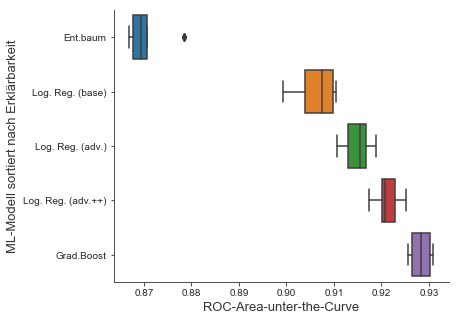

In [285]:
result_log_reg = []
result_dec_tree = []
result_gbm = []
result_log_reg_base = []
result_log_reg_advanced = []
for seeds in [0,1,2,3,4]: 
    result_log_reg.append(comp_result(logreg,X_one_hot_new,y, seed=seeds ))
    result_log_reg_advanced.append(comp_result(logreg,X_log_reg_adv,y, seed=seeds ))
    result_dec_tree.append(comp_result(dec_tree,X,y, seed=seeds ))
    result_gbm.append(comp_result(clf,X,y, seed=seeds ))
    result_log_reg_base.append(comp_result(logreg,X_one_hot,y, seed=seeds ))
data = [ result_dec_tree,result_log_reg_base,result_log_reg,result_log_reg_advanced, result_gbm]
plt.figure(figsize=(6,5), facecolor=None, edgecolor=None)
sns.set_style("white")
ax = sns.boxplot(x=data,y=['Ent.baum','Log. Reg. (base)','Log. Reg. (adv.)', 'Log. Reg. (adv.++)', 'Grad.Boost']
                )
ax.set_xlabel('ROC-Area-unter-the-Curve', color="#333333", fontsize=13)
ax.set_ylabel('ML-Modell sortiert nach Erklärbarkeit', color="#333333", fontsize=13)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



### 5x2CV Test zwischen Log. Reg. (plusplus) und der GBM

In [286]:
test_log_reg = test_evaluation(logreg,X_log_reg_adv,y)
test_gbm = test_evaluation(clf,X,y)
print(test_log_reg)
print(test_gbm)
scipy.stats.ttest_rel(test_log_reg[1],test_gbm[1])

(0.9207883259267813, [0.9179539912804959, 0.9235414425949637, 0.9197726131355424, 0.9220099484198993, 0.9174690945154298, 0.9240725987236941, 0.9178070407510981, 0.9234893253755069, 0.9224043126920413, 0.919362891779141])
(0.9268813237764257, [0.9232850146697092, 0.9301968830429779, 0.9254801756972904, 0.9272714548712255, 0.9241591448937007, 0.9306864317961523, 0.92279798806878, 0.9292300112939063, 0.9287425494612374, 0.9269635839692781])


Ttest_relResult(statistic=-23.526531011373404, pvalue=2.158688612232344e-09)

### 5x2CV Test zwischen Log. Reg. (advanced) und der  Log. Reg. (plusplus)

In [288]:
test_log_reg = test_evaluation(logreg,X_log_reg_adv,y)
test_gbm = test_evaluation(logreg,X_one_hot_new,y)
print(test_log_reg)
print(test_gbm)
scipy.stats.ttest_rel(test_log_reg[1],test_gbm[1])

(0.9207883259267813, [0.9179539912804959, 0.9235414425949637, 0.9197726131355424, 0.9220099484198993, 0.9174690945154298, 0.9240725987236941, 0.9178070407510981, 0.9234893253755069, 0.9224043126920413, 0.919362891779141])
(0.914755143345368, [0.9118431662369478, 0.9176028660484487, 0.9137835165431296, 0.9160071997914775, 0.9107547920199601, 0.9188244876638876, 0.9115020713596551, 0.9176547314318086, 0.9163170558803868, 0.9132615464779783])


Ttest_relResult(statistic=51.84040709913221, pvalue=1.8574413111744263e-12)